In [53]:
# def checkCategorical(data_frame, column, approved_list):

def checkCategorical(data_frame, column, approved_list):
    _counts = df[column].value_counts()
    not_in_list = 0
    for x in _counts.index.tolist():
        if x not in approved_list: 
            print(x)
            not_in_list += 1
    print('{} {} categories found that were not in the official {} list.'.format(not_in_list, column, column))
    print(_counts)

In [3]:
# def plotContinuous(data_frame, x, y, marker_size, size):

def plotContinuous(data_frame, x, y, marker_size, size):
    groups = data_frame.groupby('y')
    p = 0
    for name, group in groups:
        plt.plot(group[x],group[y],marker='.',ms=marker_size[p],linestyle='',label=name)
        p += 1
    plt.rcParams["figure.figsize"] = (size[0],size[1])
    plt.xlabel=x
    plt.ylabel=y
    plt.legend(prop={'size':20})
    plt.show()

In [4]:
# def mlpWrapper(df, mute):

def mlpWrapper(df, mute):
    # split into train and test data
    if not mute: print('TTT seed value: {}'.format(TTT_seed))
    train, test = train_test_split(
        df,
        test_size=0.2,
        random_state=TTT_seed
    )
    X_train = train[train.columns[:-1]]
    X_test = test[test.columns[:-1]]
    y_train = train[train.columns[-1]]
    y_test = test[test.columns[-1]]

    # useful info print out
    if not mute: print('training set size: {}'.format(train.shape[0]))
    if not mute: print('testing set size: {}'.format(test.shape[0]))

    # call training function
    if not mute: print('MLP seed value: {}'.format(MLP_seed))
    mlp = MLPClassifier(
        hidden_layer_sizes=50,
        activation='logistic',
        learning_rate_init=0.01,
        batch_size=100,
        solver='sgd',
        random_state=MLP_seed,
        max_iter=10000
    ).fit(X_train,y_train)

    # print out results
    result = mlp.predict(test[test.columns[:-1]])
    result_train = mlp.score(X_train, y_train)
    result_test = mlp.score(X_test, y_test)
    if not mute: print('Training accuracy: {:.2f}'.format(result_train))
    if not mute: print('Testing accuracy: {:.2f}'.format(result_test))

    # return
    return {'train': result_train, 'test': result_test}



In [5]:
# def oneHot(df, column):

def oneHot(df, column):

    # 1 hot encoding
    _df = pd.get_dummies(df, columns=[column], prefix=column)
    
    #return
    return _df

In [6]:
# def insert(df, insert_df):
def insert(df, insert_df):
    _left = df[df.columns[:-1]]
    _right = df[df.columns[-1]]
    _final = pd.concat([_left,insert_df,_right],axis=1)
    return _final

In [7]:
# def removeFirstCalls(df):
def removeFirstCalls(df):
    _df = df
    return _df[_df['pdays']!=999]

In [8]:
# def removePdays(df):

def removePdays(df):
    return df.drop('pdays', axis=1)

In [9]:
# def getNormalized(df, remove_pdays):

def getNormalized(df, remove_pdays):

    # selection list for readability
    selection = [
        'age',
        'campaign',
        'pdays',
        'previous',
        'emp.var.rate',
        'cons.price.idx',
        'cons.conf.idx',
        'euribor3m',
        'nr.employed',
        'y'
    ]
    if remove_pdays: selection.remove('pdays')

    # scrub dataframe: no first selection and no first time subs
    _df = df[selection]

    # max/min normalization
    _norm = _df[_df.columns[:-1]]
    _norm = (_norm - _norm.mean()) / (_norm.max() - _norm.min())
    
    # reassemble
    _final = pd.concat([_norm, _df['y']], axis=1)
    
    #return
    return _final

In [10]:
# def getJob(df):

def getJob(df):

    # 1 hot encoding
    _jobs = df['job']
    
    # print(_jobs.value_counts())
    _jobs = oneHot(_jobs, 'job')

    # output
    # print(_jobs.head())

    return _jobs

In [11]:
# def getMarital(df):

def getMarital(df):

    # 1 hot encoding
    _marital = df['marital']
    # print(_marital.value_counts())
    _marital = oneHot(_marital, 'marital')
    _marital = _marital.drop('marital_unknown',axis=1)

    # output
    # print(_marital.head())

    return _marital

In [12]:
# def getEducation(df):

def getEducation(df):

    # replace
    _encoded_education = {
        'education': {
            'unknown': 0/7,
            'illiterate': 1/7,
            'basic.4y': 2/7,
            'basic.6y': 3/7,
            'basic.9y': 4/7,
            'high.school': 5/7,
            'professional.course': 6/7,
            'university.degree': 7/7,
        }
    }
    # print(_education.education.value_counts())
    _education = df.replace(_encoded_education)
    _education = _education.education

    # output
    # print(_education.head())

    return _education

In [13]:
# def getDefault(df):

def getDefault(df):

    # 1 hot encoding
    _default = df.default
    # print(_default.value_counts())
    _default = oneHot(_default, 'default')
    _default = _default.drop('default_unknown',axis=1)

    # output
    # print(_default.head())

    return _default

In [14]:
# def getHousing(df):

def getHousing(df):

    # 1 hot encoding
    _housing = df.housing
    # print(_housing.value_counts())
    _housing = oneHot(_housing, 'housing')
    _housing = _housing.drop('housing_unknown',axis=1)

    # output
    # print(_housing.head())

    return _housing

In [15]:
# def getLoan(df):

def getLoan(df):

    # 1 hot encoding
    _loan = df.loan
    # print(_loan.value_counts())
    _loan = oneHot(_loan, 'loan')
    _loan = _loan.drop('loan_unknown',axis=1)

    # output
    # print(_loan.head())

    # return
    return _loan

In [16]:
# def getContact(df):

def getContact(df):

    # 1 hot encoding
    _contact = df.contact
    # print(_contact.value_counts())
    _contact = oneHot(_contact, 'contact')

    # output
    # print(_contact.head())

    # return
    return _contact

In [17]:
# def getMonth(df):

def getMonth(df):

    # 1 hot encoding
    _month = df.month
    # print(_month.value_counts())
    _month = oneHot(_month, 'month')

    # output
    # print(_month.head())

    # return
    return _month

In [18]:
# def getDayOfWeek(df):

def getDayOfWeek(df):

    # 1 hot encoding
    _day_of_week = df.day_of_week
    # print(_day_of_week.value_counts())
    _day_of_week = oneHot(_day_of_week, 'day_of_week')

    # output
    # print(_day_of_week.head())

    # return
    return _day_of_week

In [19]:
# def getPoutcome(df):

def getPoutcome(df):

    # 1 hot encoding
    _poutcome = df.poutcome
    # print(_poutcome.value_counts())
    _poutcome = oneHot(_poutcome, 'poutcome')

    # output
    # print(_poutcome.head())

    # return
    return _poutcome

In [20]:
# def assembleReady(df, remove_first_call, remove_pdays):

def assembleReady(df, remove_first_call, remove_pdays):
    ready = {}
    if remove_first_call and not remove_pdays: _df = removeFirstCalls(df)
    if not remove_first_call and remove_pdays: _df = removePdays(df)
    if not remove_first_call and not remove_pdays: _df = df
    ready['normalized'] = getNormalized(_df, remove_pdays)
    ready['job'] = getJob(_df)
    ready['marital'] = getMarital(_df)
    ready['education'] = getEducation(_df) 
    ready['default'] = getDefault(_df)
    ready['housing'] = getHousing(_df)
    ready['loan'] = getLoan(_df)
    ready['contact'] = getContact(_df)
    ready['month'] = getMonth(_df)
    ready['day_of_week'] = getDayOfWeek(_df)
    ready['poutcome'] = getPoutcome(_df)
    return ready

In [21]:
# def assembleData(normalized, ready):
def assembleData(normalized, ready):
    all_data = normalized
    for key in ready:
        if key != 'normalized':
            # print('adding {}...'.format(key))
            all_data = insert(all_data, ready[key])
    return all_data

In [22]:
# def testLoop(ready, number_of_tests)

def testLoop(df, number_of_tests):

    # initialize return variable
    _all_runs = []

    # loop
    for _i in range(number_of_tests):
        
        # user feed back
        if _i == 0 or _i % 10 == 9: print('running test {}'.format(_i+1))
        
        # loop intializations
        _this_run = {}
        random.seed()
        TTT_seed = randint(0,99)
        MLP_seed = randint(0,99)
        
        # conduct tests
        _results = mlpWrapper(df, True)

        # load results
        _this_run['TTT_seed'] = TTT_seed
        _this_run['MLP_seed'] = MLP_seed
        _this_run['train'] = _results['train']
        _this_run['test'] = _results['test']

        # append results
        _all_runs.append(_this_run)

    # return results
    return pd.DataFrame(_all_runs)

In [23]:
# def buildIterationList()

def buildIterationList():
    
    keys = [
        'job',
        'marital',
        'education',
        'default',
        'housing',
        'loan',
        'contact',
        'month',
        'day_of_week',
        'poutcome'
    ]

    build_list = []
    for i in range(0,len(keys)):
        new_key = 'normalized' '+' + keys[i]
        build_list.append(new_key)
        for j in range(0,len(keys)):
            if j > i:
                new_key += '+' + keys[j]
                build_list.append(new_key)

    return build_list

In [24]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from random import randint
import random
import pprint

In [25]:
# LOAD DATA
file_name = '../bank-additional/bank-additional/bank-additional-full.csv'
df = pd.read_csv(file_name, sep=';')
df = df.drop_duplicates(keep='first')
TTT_seed = randint(0,99)
MLP_seed = randint(0,99)
_ready = {}
pp = pprint.PrettyPrinter(indent=4)

In [96]:
# THE PROBLEM WITH FIRST TIME CALL DATA
_counts = df.pdays.value_counts()
print('First time calls represented {:.0%} of the total number of calls.'.format(_counts.max()/df.shape[0]))
_no = df[df['y']=='no']
_counts = _no.pdays.value_counts()
print('{:.0%} of the calls were first time calls where the customer declined the offer.'.format(_counts.max()/df.shape[0]))

First time calls represented 96% of the total number of calls.
87% of the calls were first time calls where the customer declined the offer.


In [99]:
# THE PROBLEM WITH FIRST TIME CALL DATA
_counts = df.previous.value_counts()
print('First time calls represented {:.0%} of the total number of calls.'.format(_counts.max()/df.shape[0]))
_no = df[df['y']=='no']
_counts = _no.previous.value_counts()
print('{:.0%} of the calls were first time calls where the customer declined the offer.'.format(_counts.max()/df.shape[0]))

First time calls represented 86% of the total number of calls.
79% of the calls were first time calls where the customer declined the offer.


In [27]:
# KEEP PDAYS COLUMN REMOVE FIRST CALL ROWS

# prep data
_ready = assembleReady(df, True, False)
_data = {
    'normalized': _ready['normalized'],
    'all': assembleData(_ready['normalized'], _ready)
}
number_of_tests = 0

# run tests
no_first_call_result = testLoop(_data, number_of_tests)


# results 
if number_of_tests != 0:
    print(no_first_call_result.normalized_test.mean())
    print(no_first_call_result.all_test.mean())
else:
    print('BYPASSED')

BYPASSED


In [28]:
# REMOVE PDAYS COLUMN

# prep data
_ready = assembleReady(df, False, True)
_data = {
    'normalized': _ready['normalized'],
    'all': assembleData(_ready['normalized'], _ready)
}
number_of_tests = 0

# run tests
removed_pday_column_resut = testLoop(_data, number_of_tests)

# results
if number_of_tests != 0:
    print(removed_pday_column_resut.normalized_test.mean())
    print(removed_pday_column_resut.all_test.mean())
else:
    print('BYPASSED')

BYPASSED


In [29]:
# COMBINATIONS WITH PDAYS REMOVED

# prep data
_ready = assembleReady(df, False, True)
_data = {
    'normalized': _ready['normalized'],
    'all': assembleData(_ready['normalized'], _ready)
}
number_of_tests = 0

# run tests
removed_pday_column_resut = testLoop(_data, number_of_tests)

# results
if number_of_tests != 0:
    print(removed_pday_column_resut.normalized_test.mean())
    print(removed_pday_column_resut.all_test.mean())
else:
    print('BYPASSED')

BYPASSED


In [30]:
# def runCombinationTests()

def runCombinationTests(df, remove_first_call, remove_pdays):

    # get separated dataframes
    ready = assembleReady(df, remove_first_call, remove_pdays)
    
    # build work list
    build_list = buildIterationList()

    # initialize dictionary
    _selections = []
    _TTT_seeds = []
    _MLP_seeds = []
    _tests = []
    _trainings = []

    # run tests
    for i,key in enumerate(build_list):

        # build data frames
        requests = key.split('+')
        for request in requests:
            if request != 'normalized':
                builder = insert(ready['normalized'], ready[request])

        # run test
        # print(builder.head())
        print('MLP using columns {}'.format(key.replace('+',', ')))
        this_test = testLoop(builder, 1)

        # print results
        print('Training accuracy: {:.4%}'.format(this_test.train.mean()))
        print('Testing accuracy: {:.4%}'.format(this_test.test.mean()))
        print()

        # build output dataframe
        _selections.append(key)  
        print(this_test)
        _TTT_seeds.append(this_test.iloc[0, 0])
        _MLP_seeds.append(this_test.iloc[0,1]) 
        _tests.append(this_test.iloc[0,2]) 
        _trainings.append(this_test.iloc[0,3])

    # create output dataframe
    _rows = {}
    _rows['selections'] = _selections
    _rows['TTT_seed'] = _TTT_seeds
    _rows['MLP_seeds'] = _MLP_seeds
    _rows['tests'] = _tests
    _rows['train'] = _trainings
    results_df = pd.DataFrame.from_dict(_rows)

    # write results dataframe to file
    f = open('results.csv','w')
    results_df.to_csv(f)
    f.close()

In [31]:
# runCombinationTests(df, False, True)

In [42]:
results = pd.read_csv('results.csv')
print(results.tests.value_counts(ascending=True))

0.889860     1
0.889951     3
0.889192     4
0.888980     5
0.889071     6
0.890741     7
0.891287     9
0.889010    10
0.898573    10
Name: tests, dtype: int64


In [48]:
print(df.dtypes)

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object


age frequency


<AxesSubplot:>

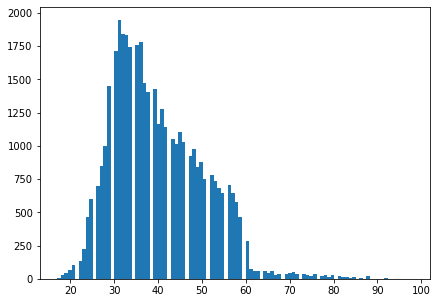

In [74]:
print('age frequency')
df['age'].hist(bins=100,grid=False,figsize=(7,5))

job frequency


<AxesSubplot:>

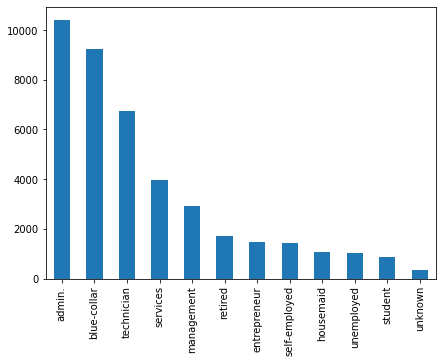

In [78]:
print('job frequency')
df['job'].value_counts().plot(kind='bar',figsize=(7,5))

pdays frequency


<AxesSubplot:>

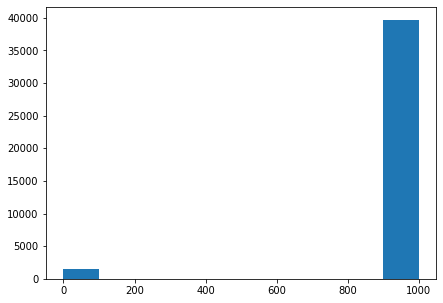

In [81]:
print('pdays frequency')
df['pdays'].hist(grid=False,figsize=(7,5))

job frequency


<AxesSubplot:>

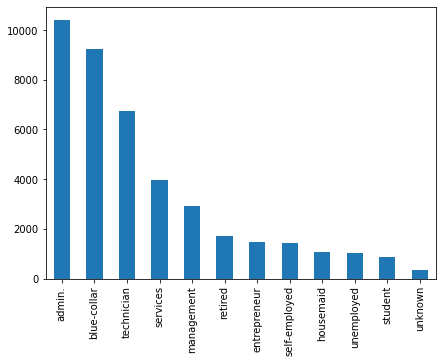

In [ ]:
print('job frequency')
df['job'].value_counts().plot(kind='bar',figsize=(7,5))

In [97]:
print(df['pdays'].value_counts().head())

999    39661
3        439
6        412
4        118
9         64
Name: pdays, dtype: int64


In [98]:
print(df['previous'].value_counts().head())

0    35551
1     4561
2      754
3      216
4       70
Name: previous, dtype: int64


previous frequency


<AxesSubplot:>

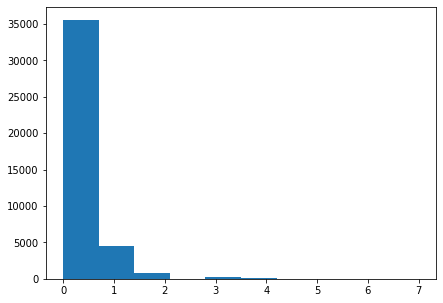

In [91]:
print('previous frequency')
df['previous'].hist(grid=False,figsize=(7,5))

previous frequency


array([<AxesSubplot:title={'center':'no'}>,
       <AxesSubplot:title={'center':'yes'}>], dtype=object)

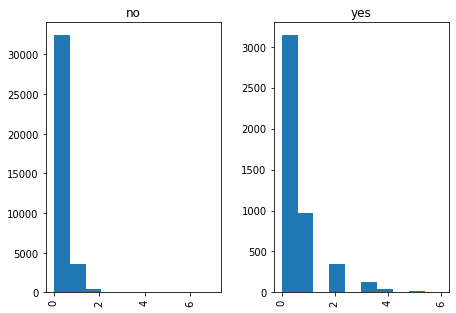

In [92]:
print('previous frequency')
df['previous'].hist(by=df['y'],grid=False,figsize=(7,5))

duration frequency


array([<AxesSubplot:title={'center':'no'}>,
       <AxesSubplot:title={'center':'yes'}>], dtype=object)

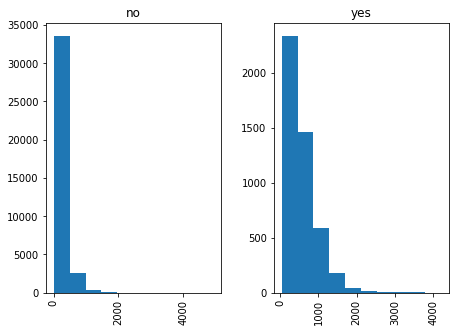

In [93]:
print('duration frequency')
df['duration'].hist(by=df['y'],grid=False,figsize=(7,5))

pdays frequency yes or no


array([<AxesSubplot:title={'center':'no'}>,
       <AxesSubplot:title={'center':'yes'}>], dtype=object)

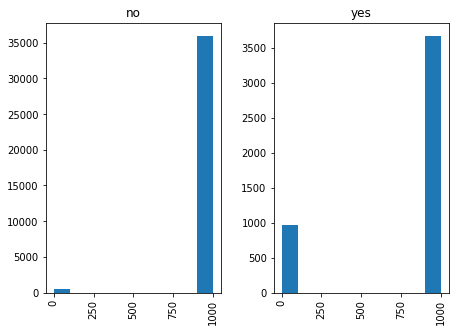

In [94]:
print('pdays frequency yes or no')
df['pdays'].hist(by=df['y'],grid=False,figsize=(7,5))

age frequency yes or no


array([<AxesSubplot:title={'center':'no'}>,
       <AxesSubplot:title={'center':'yes'}>], dtype=object)

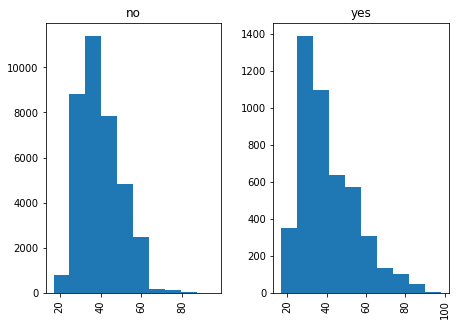

In [95]:
print('age frequency yes or no')
df['age'].hist(by=df['y'],grid=False,figsize=(7,5))

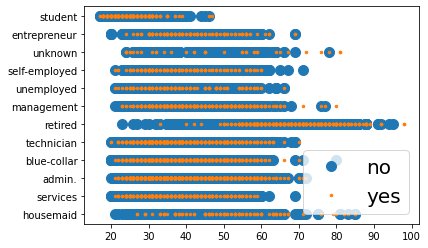

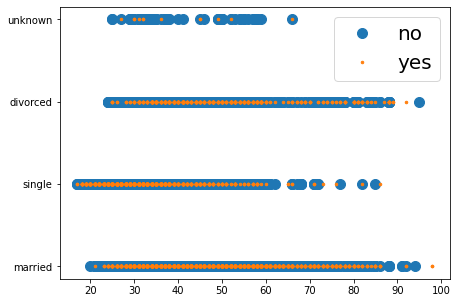

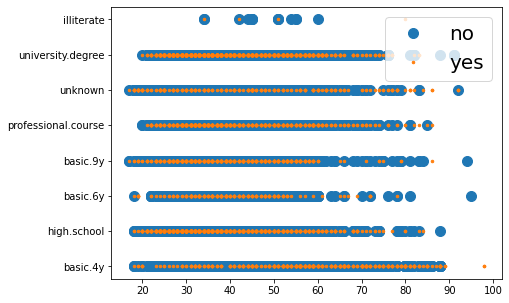

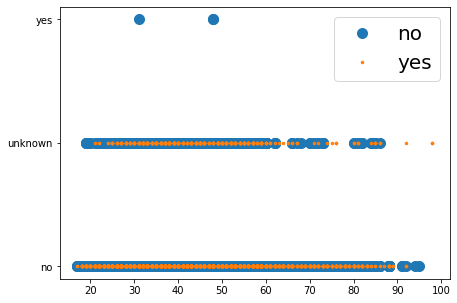

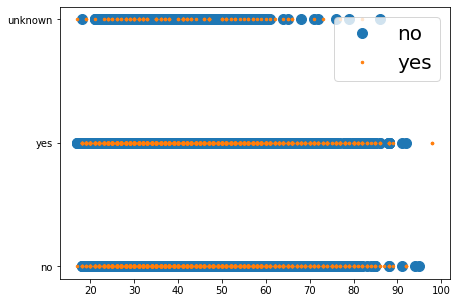

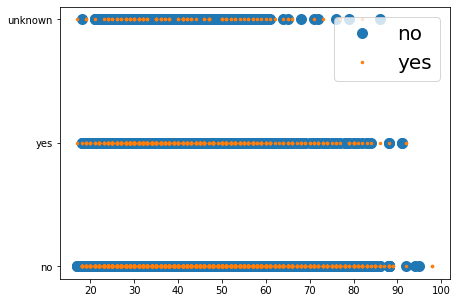

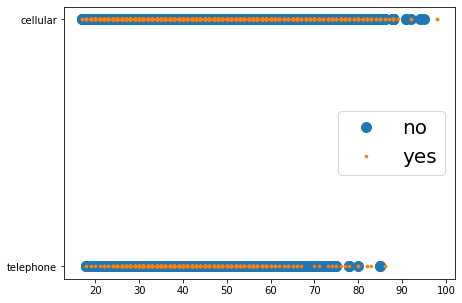

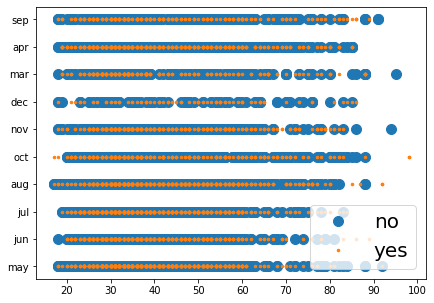

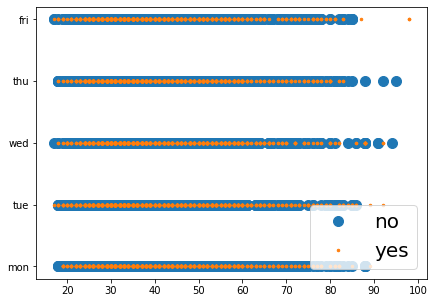

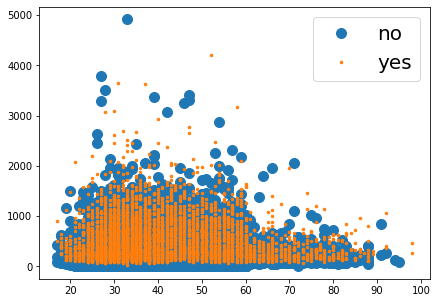

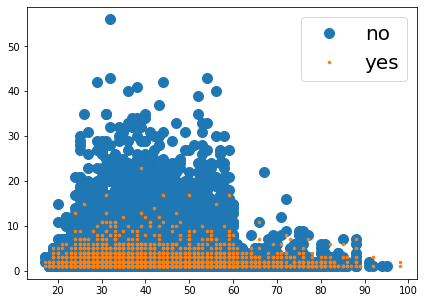

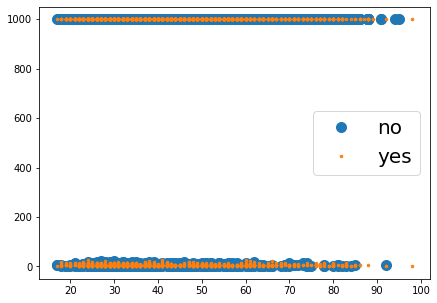

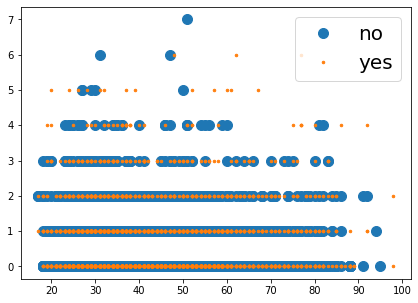

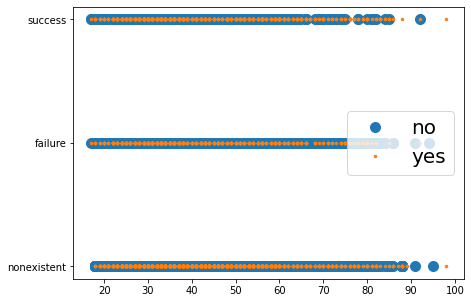

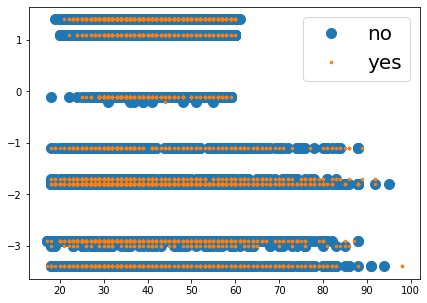

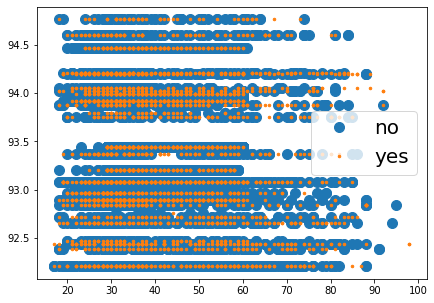

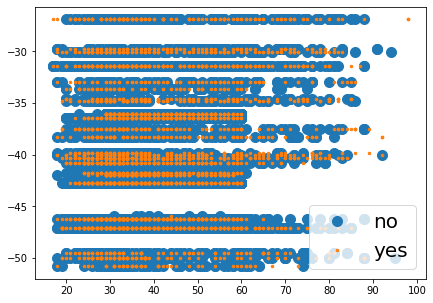

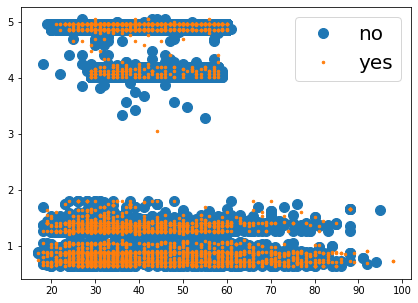

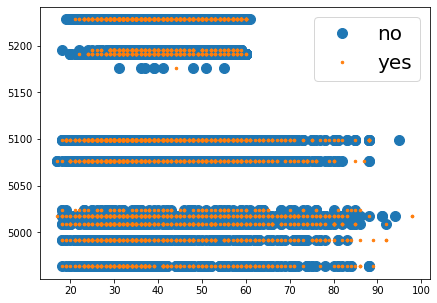

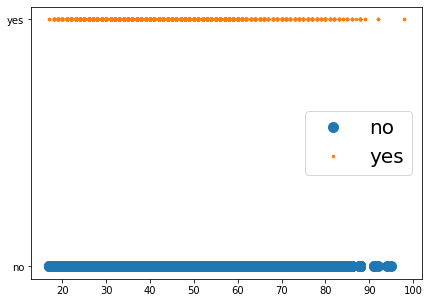

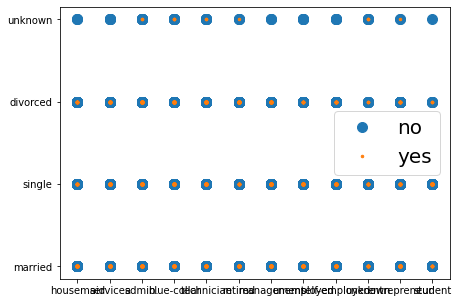

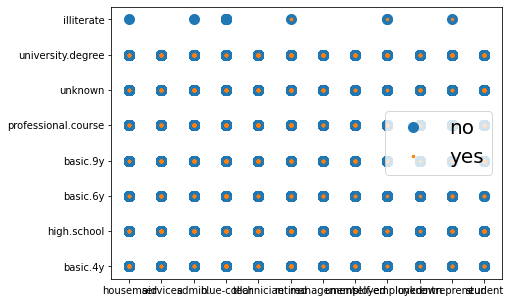

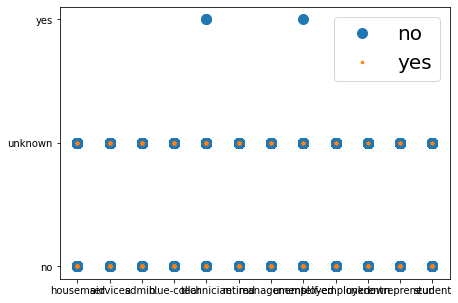

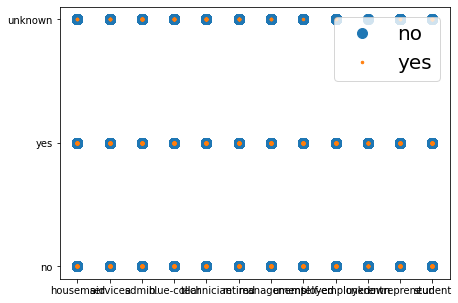

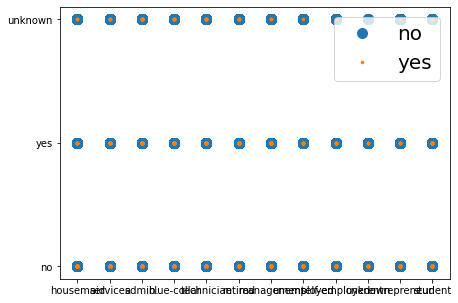

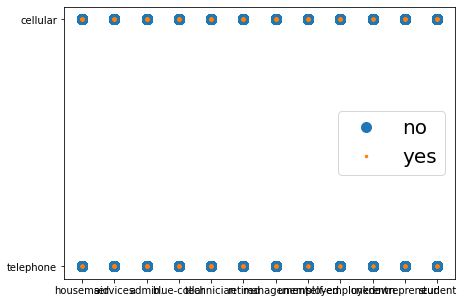

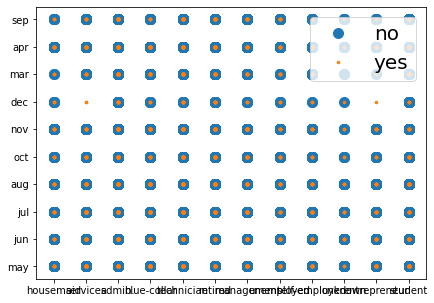

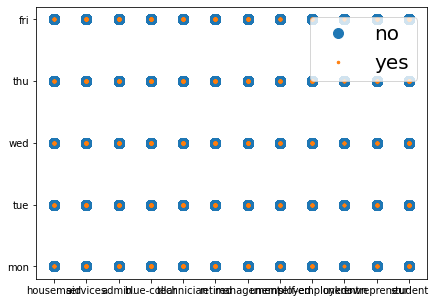

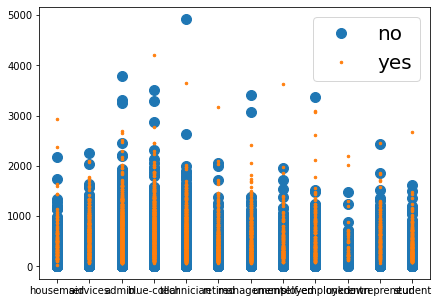

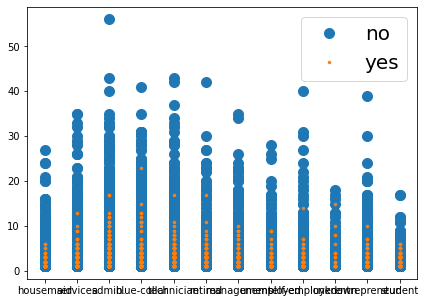

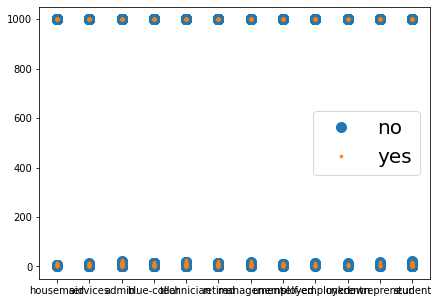

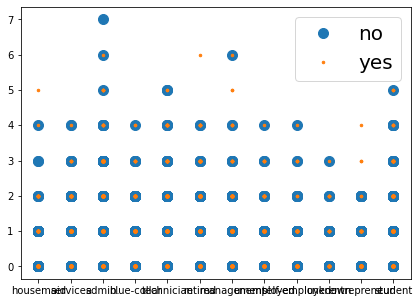

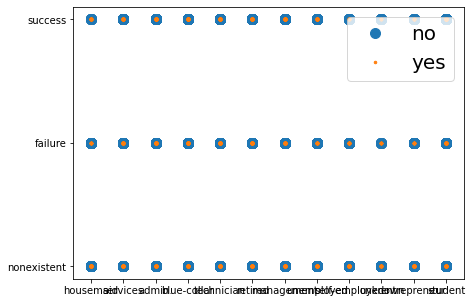

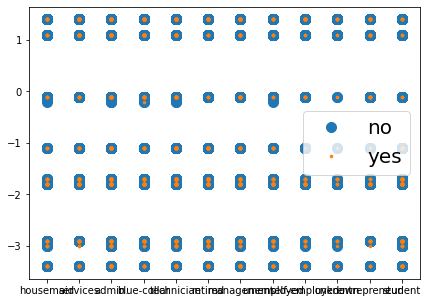

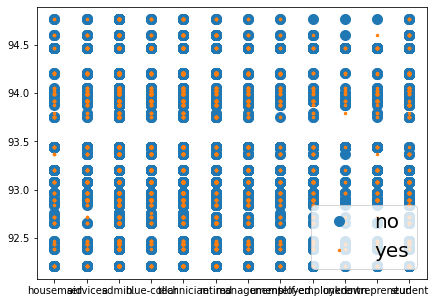

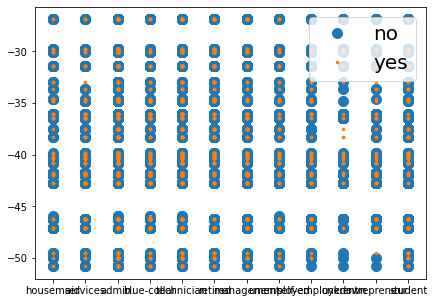

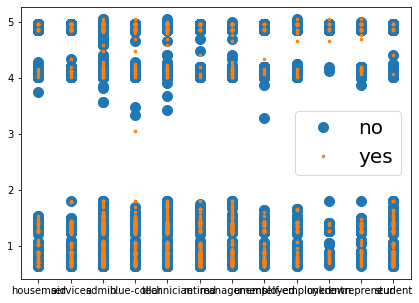

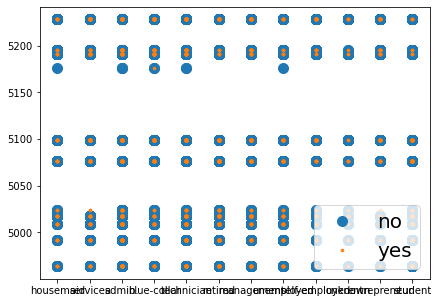

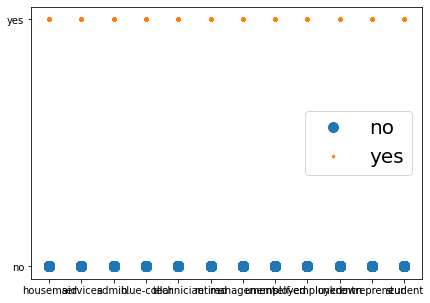

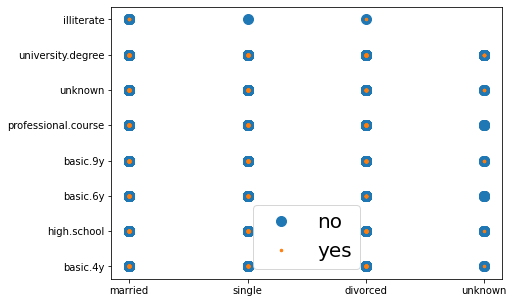

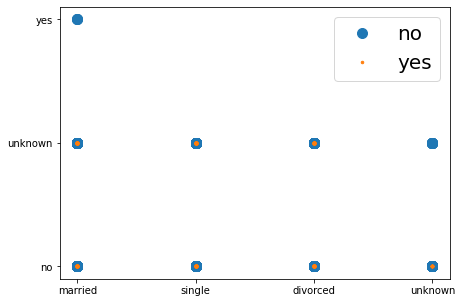

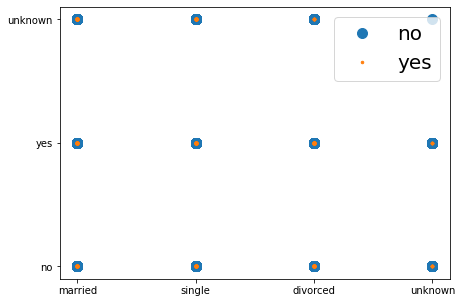

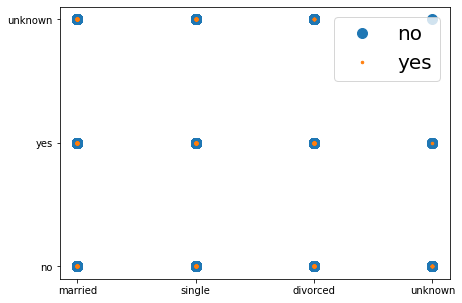

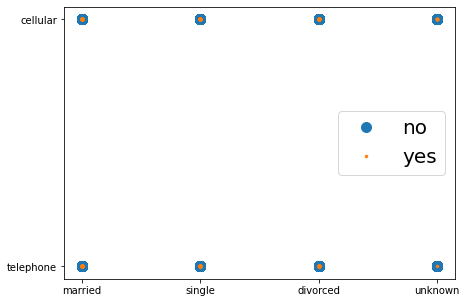

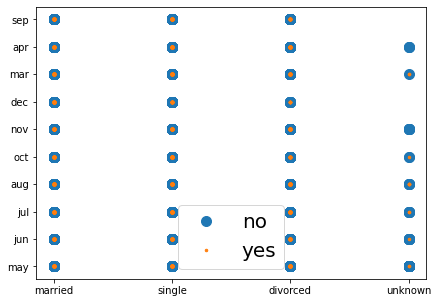

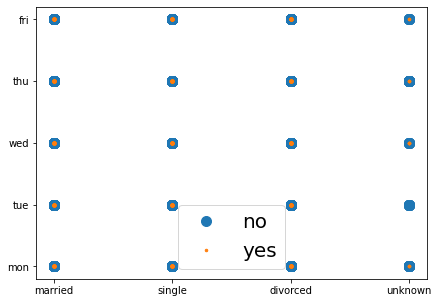

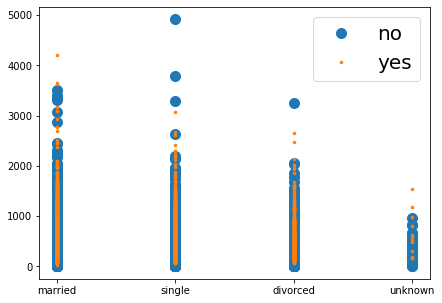

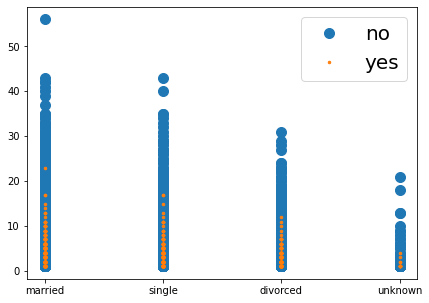

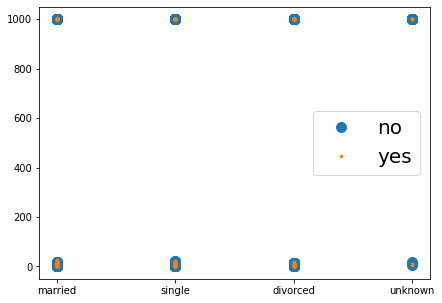

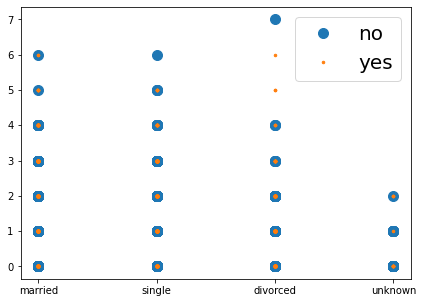

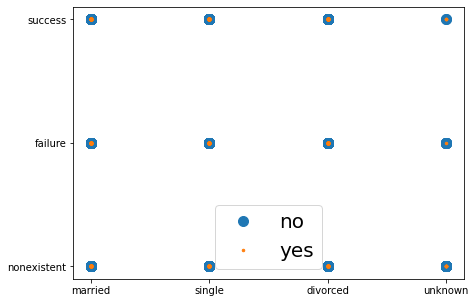

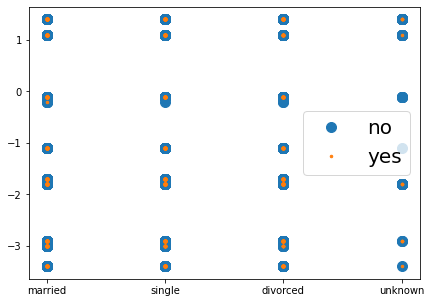

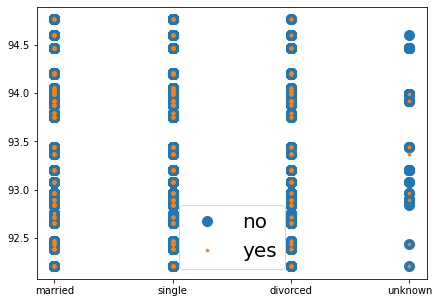

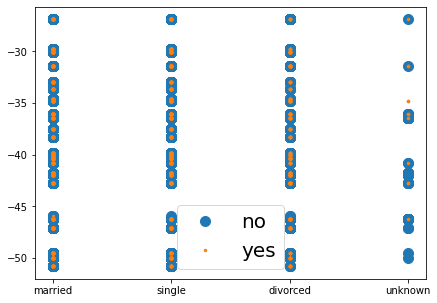

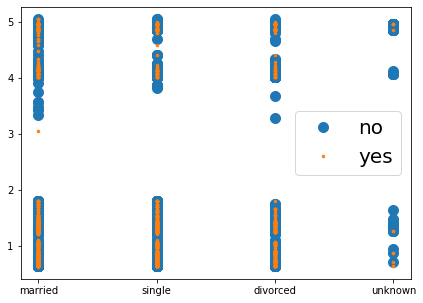

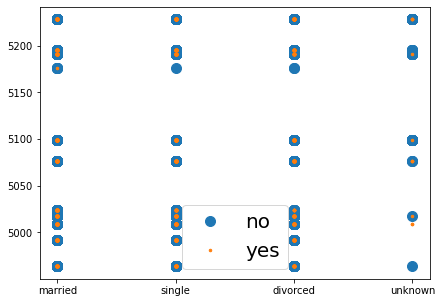

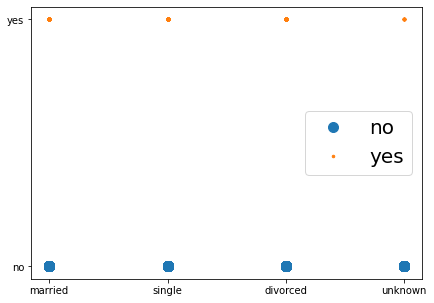

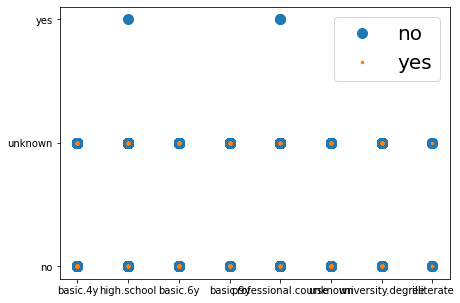

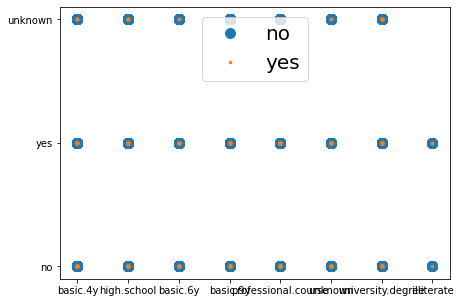

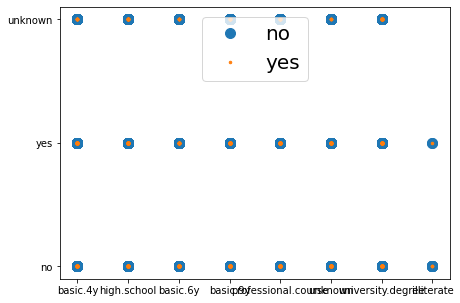

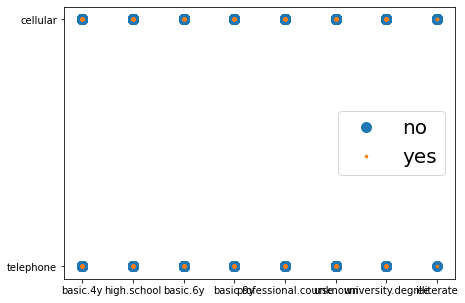

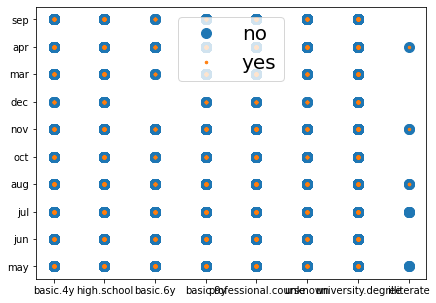

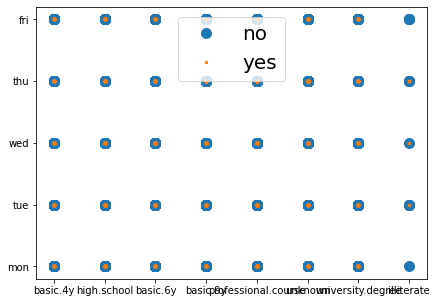

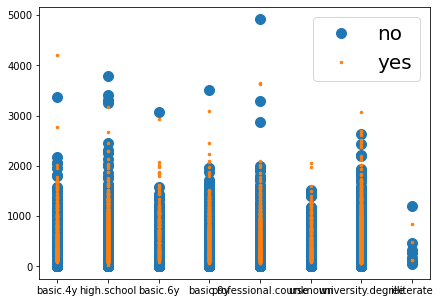

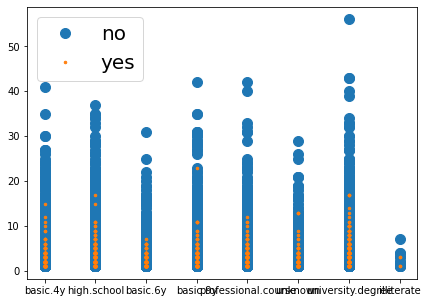

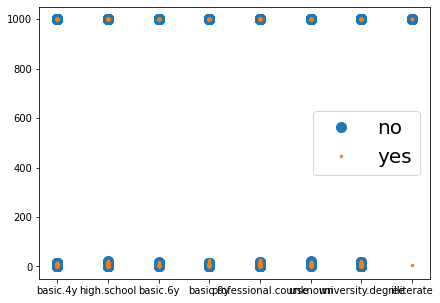

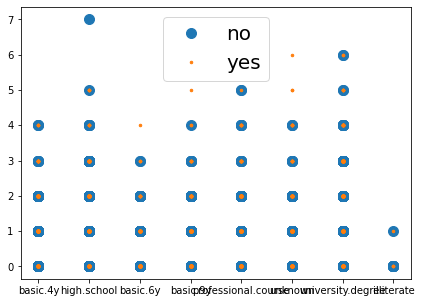

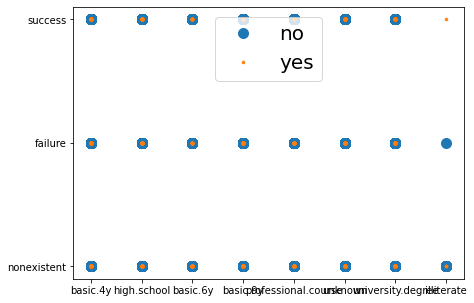

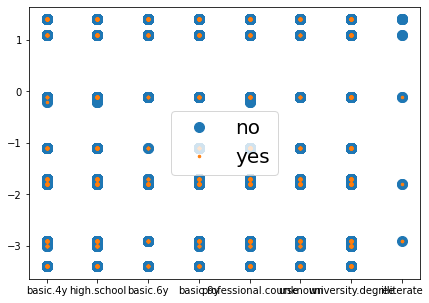

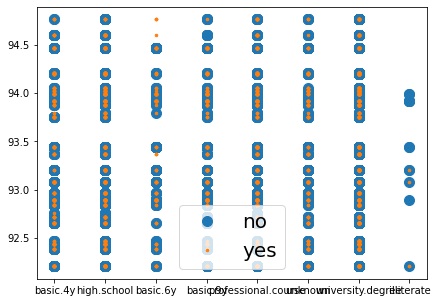

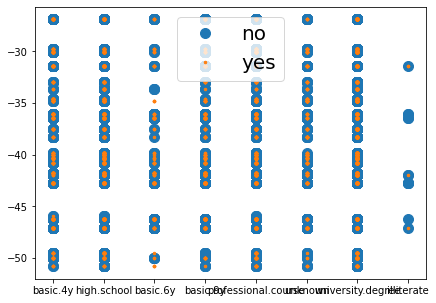

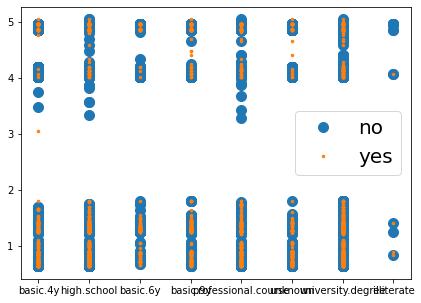

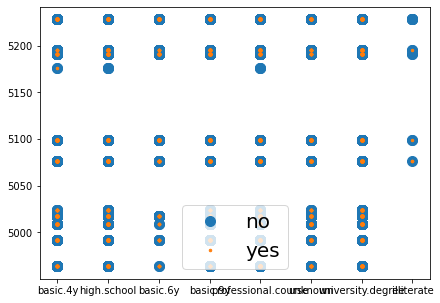

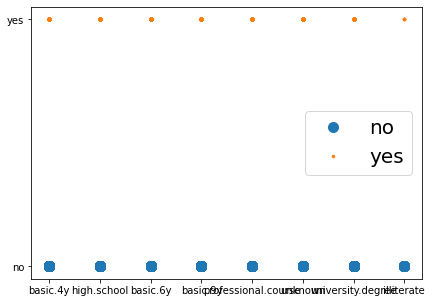

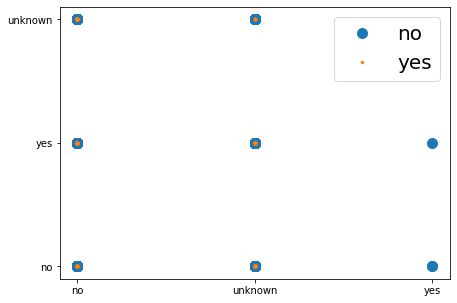

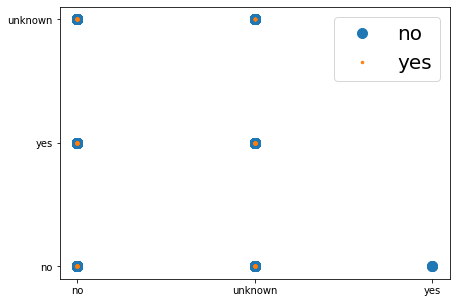

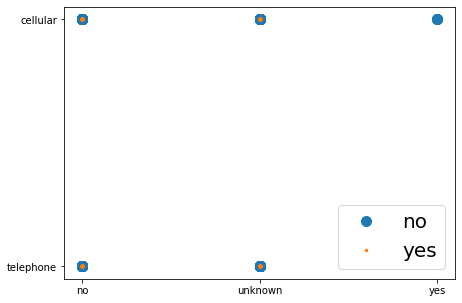

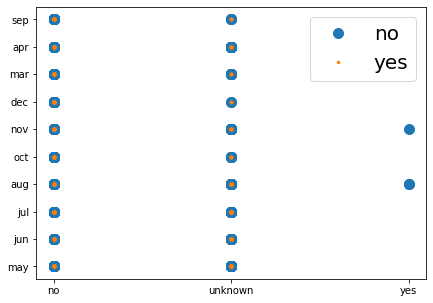

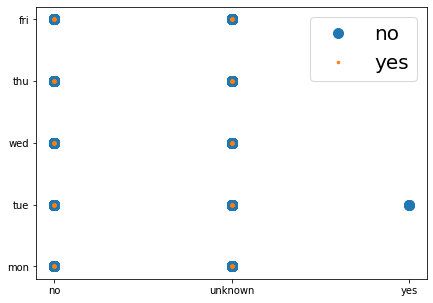

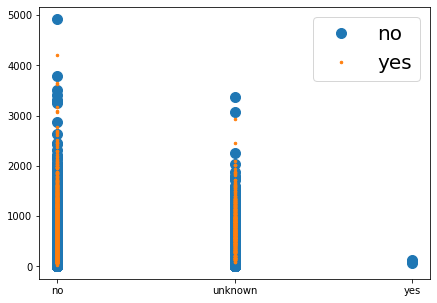

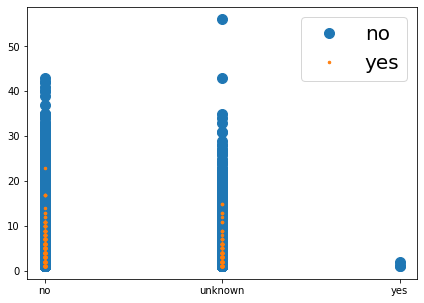

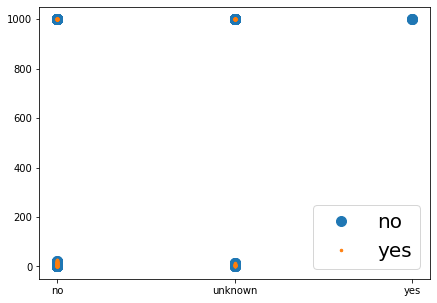

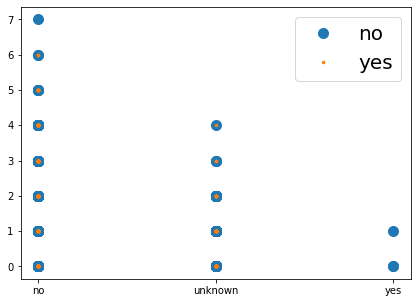

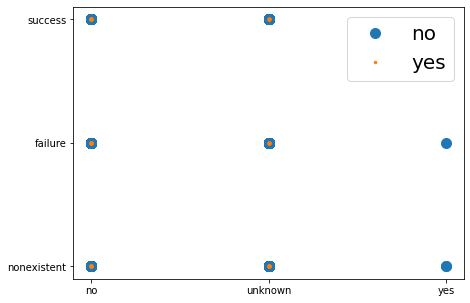

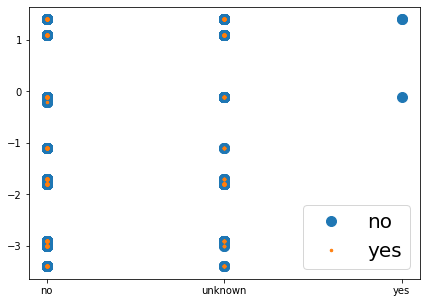

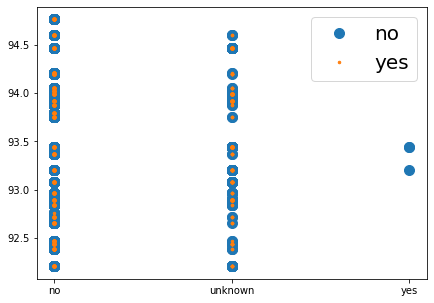

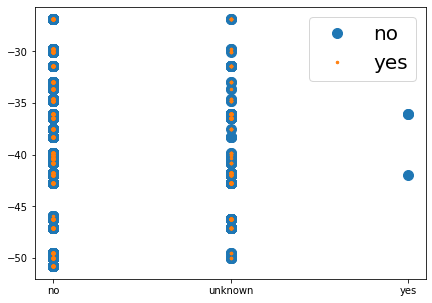

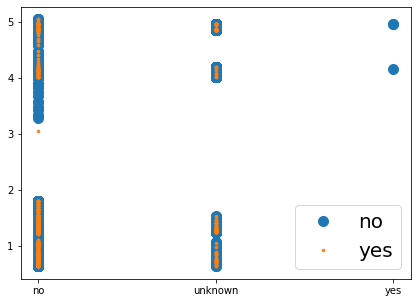

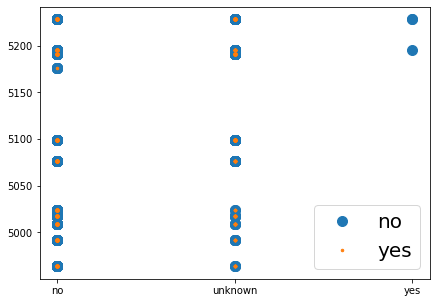

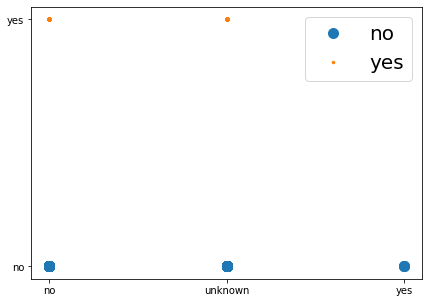

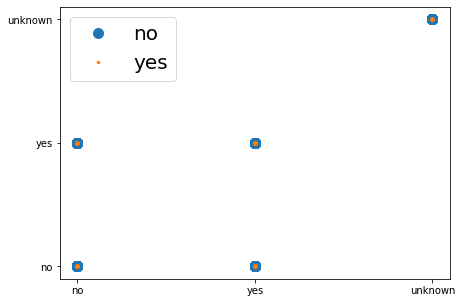

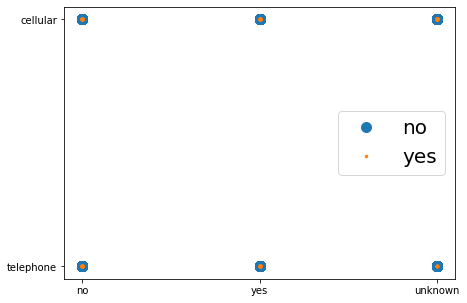

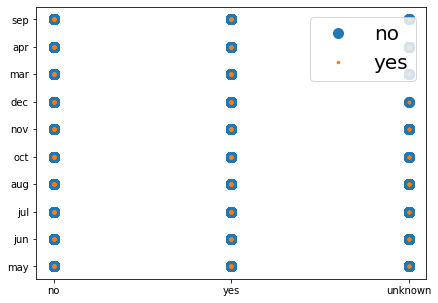

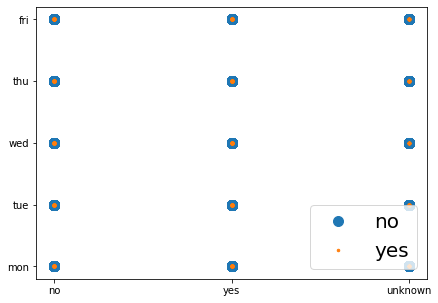

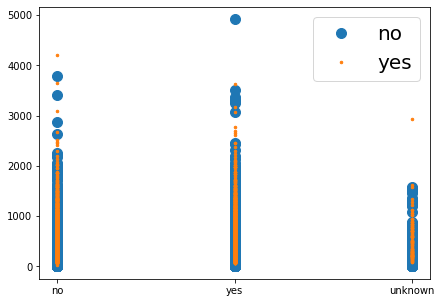

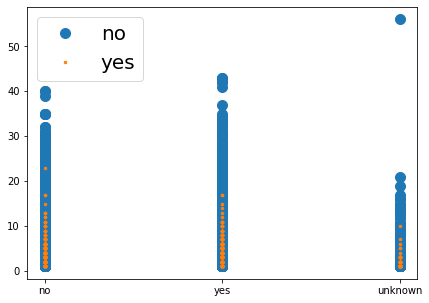

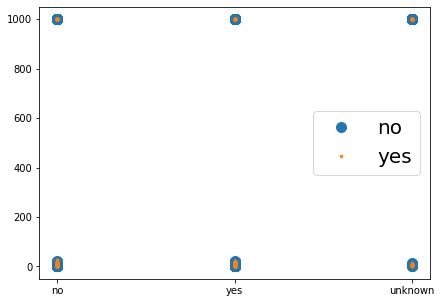

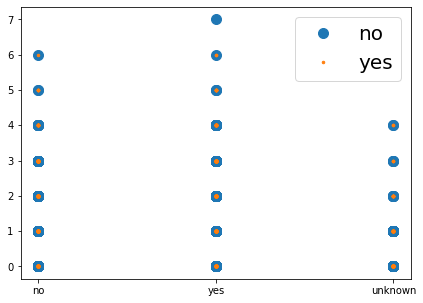

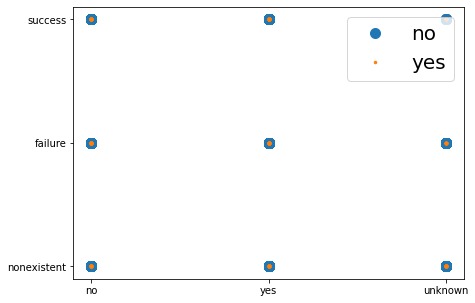

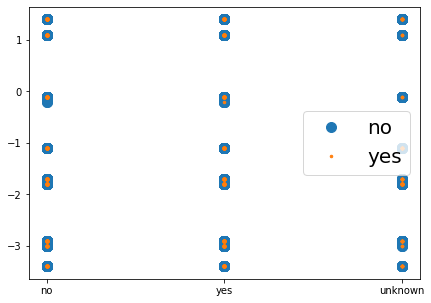

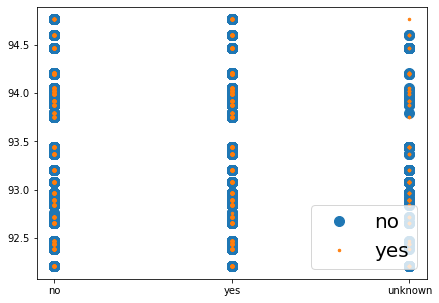

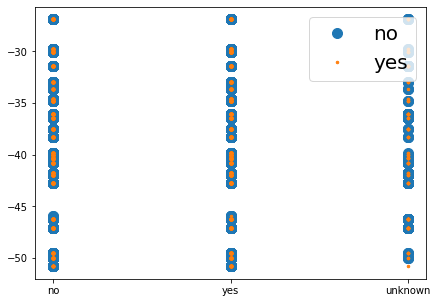

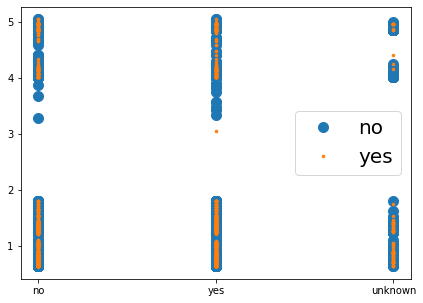

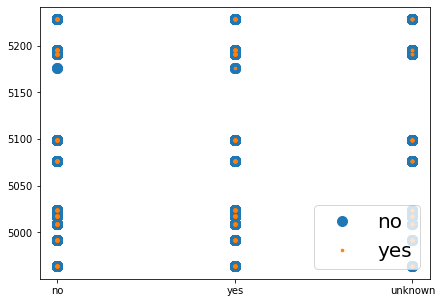

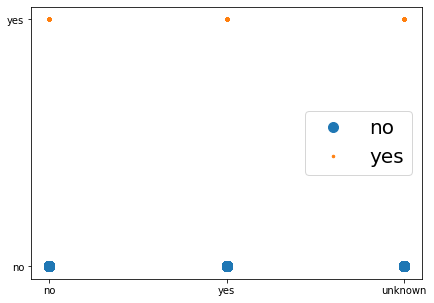

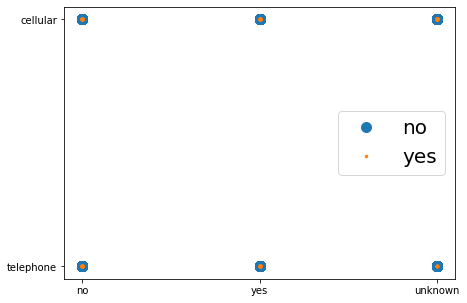

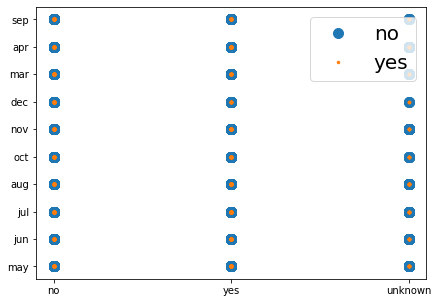

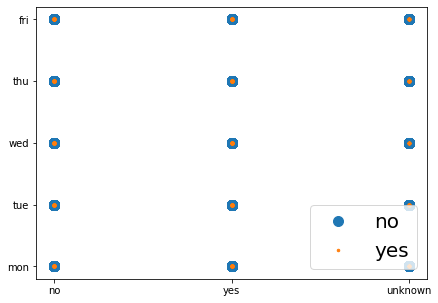

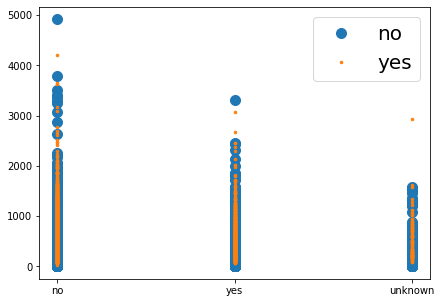

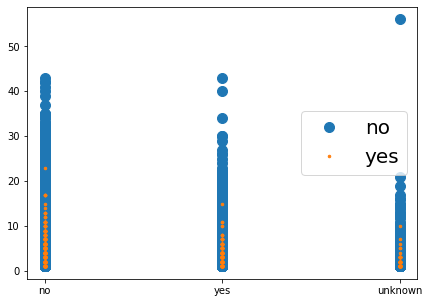

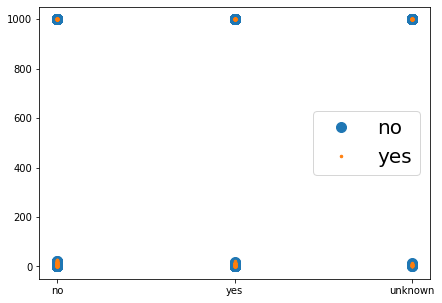

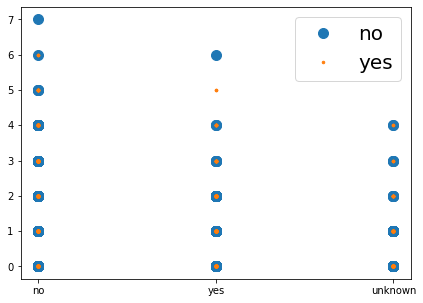

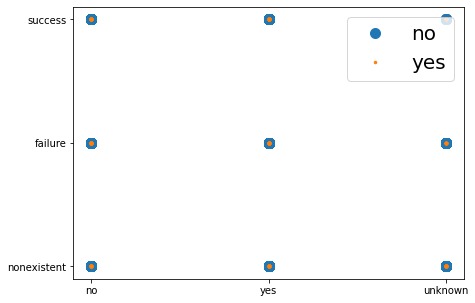

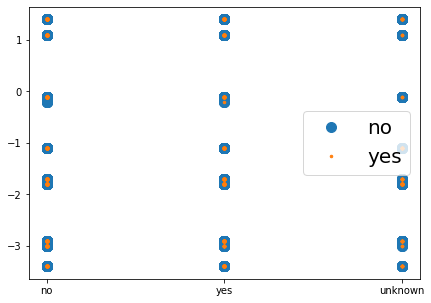

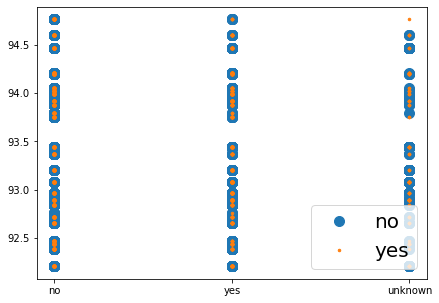

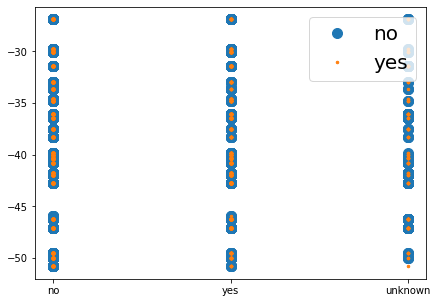

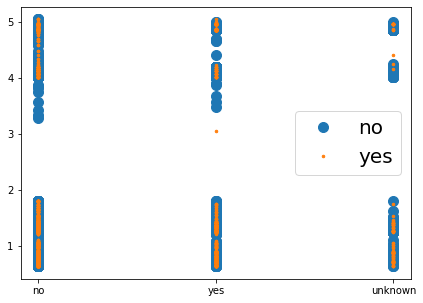

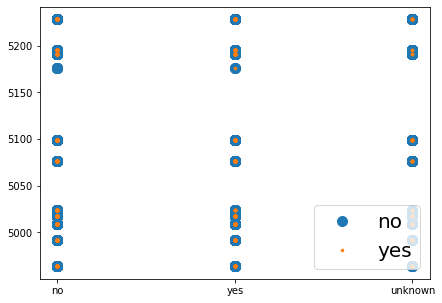

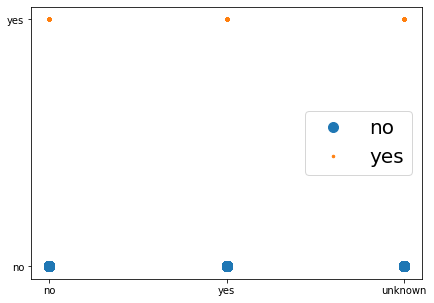

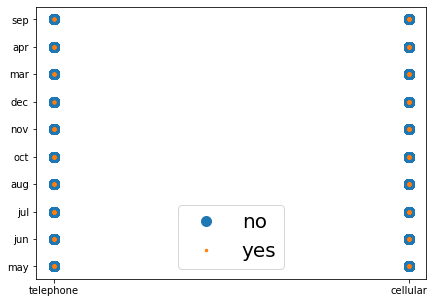

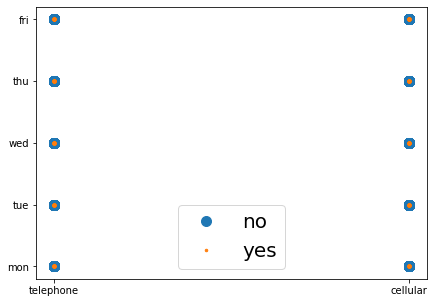

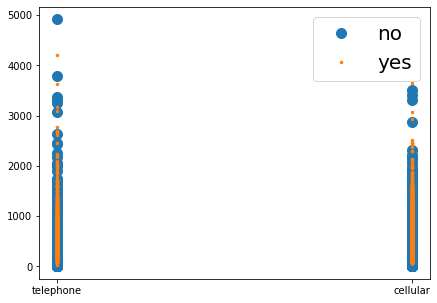

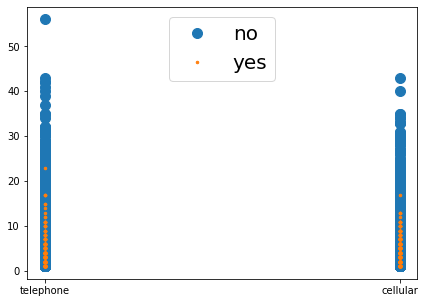

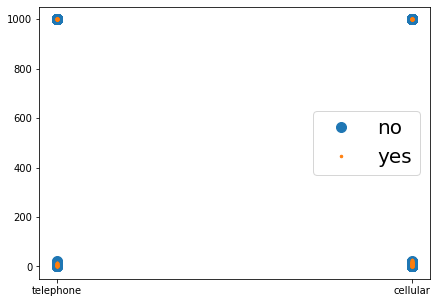

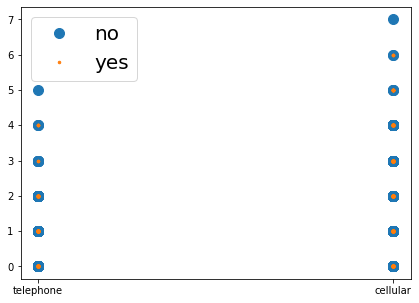

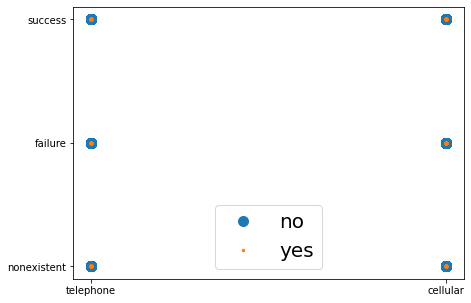

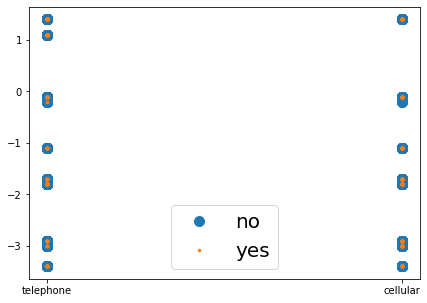

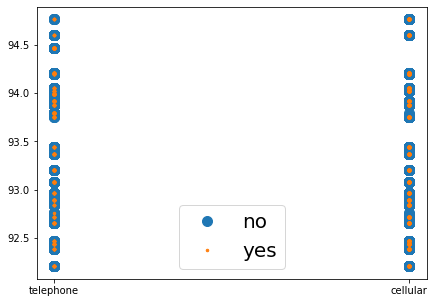

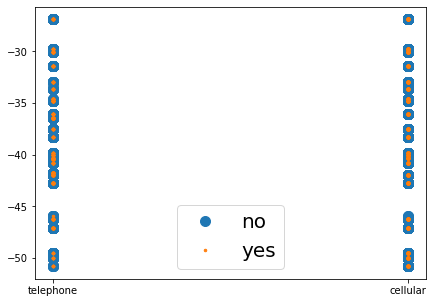

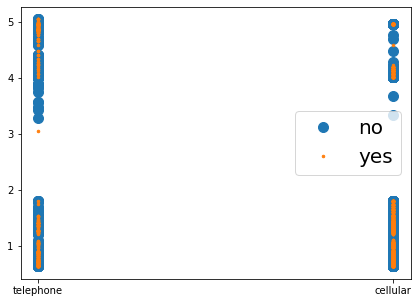

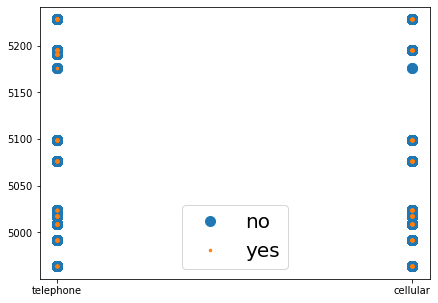

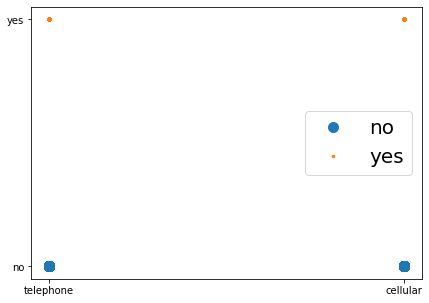

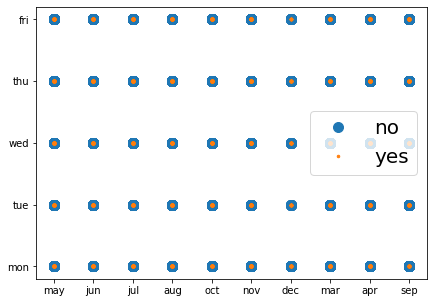

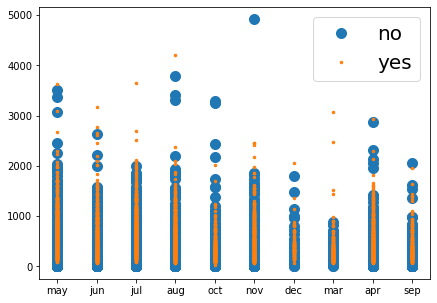

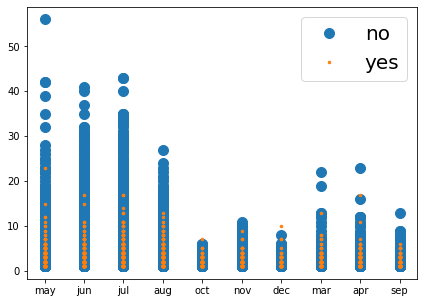

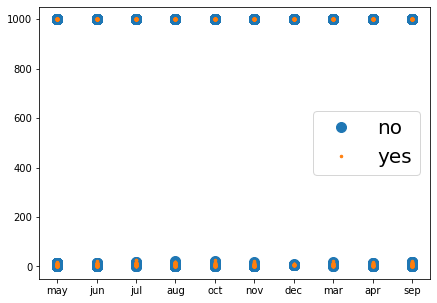

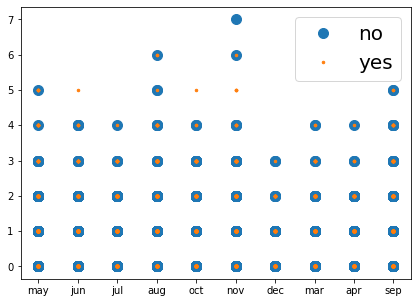

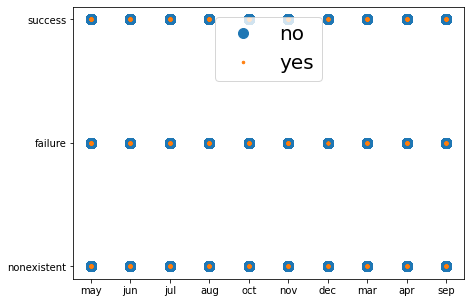

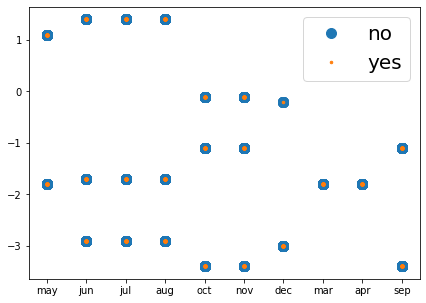

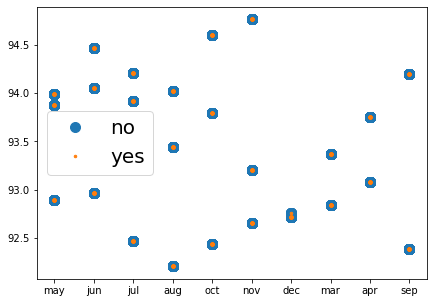

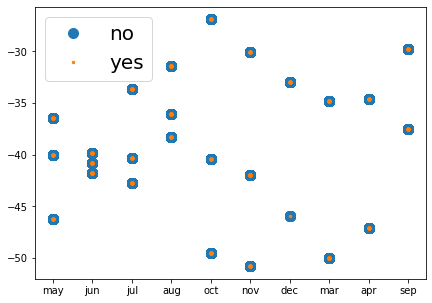

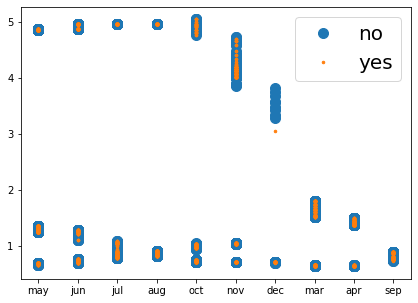

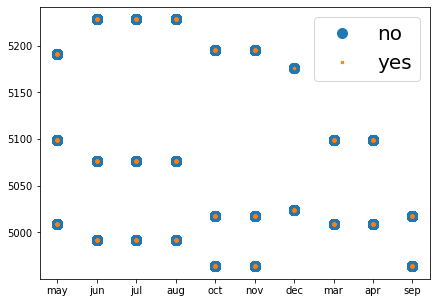

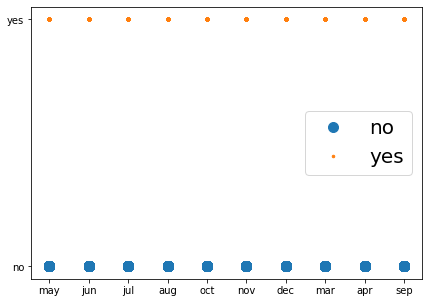

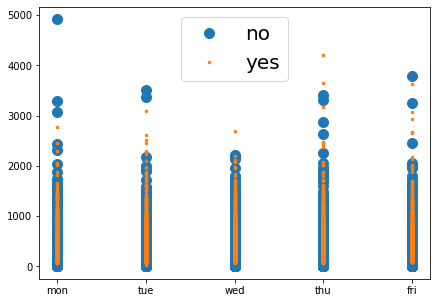

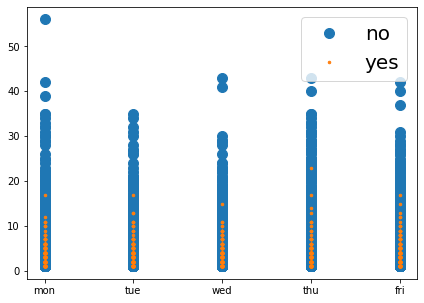

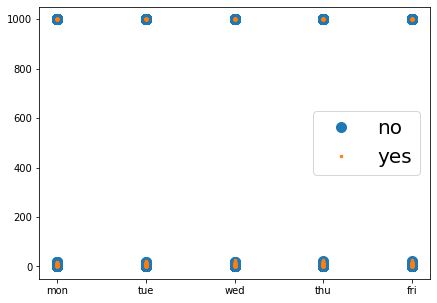

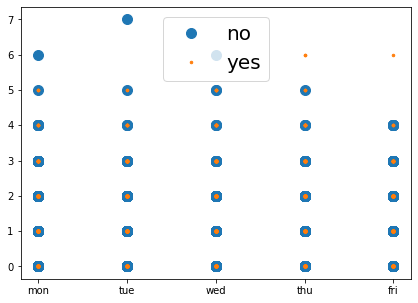

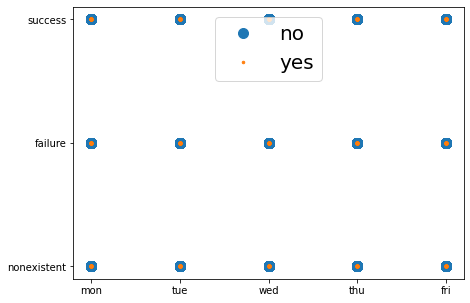

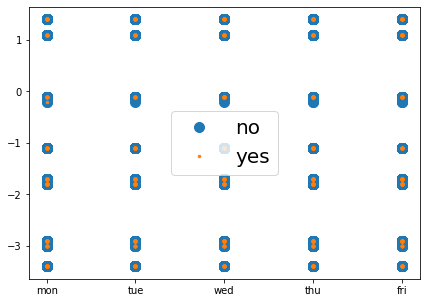

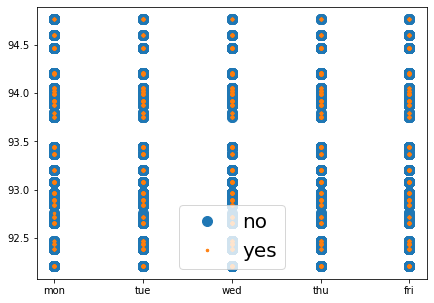

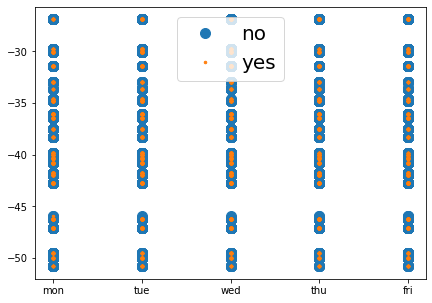

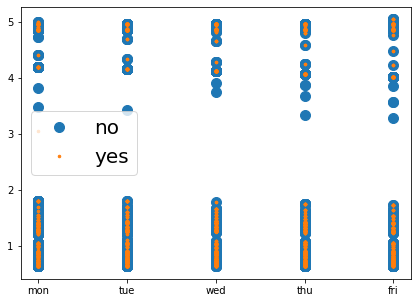

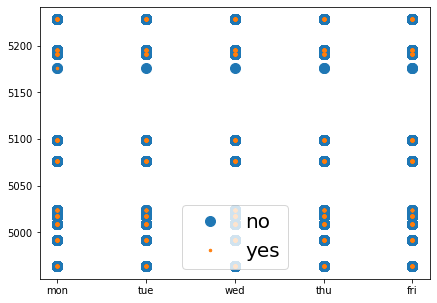

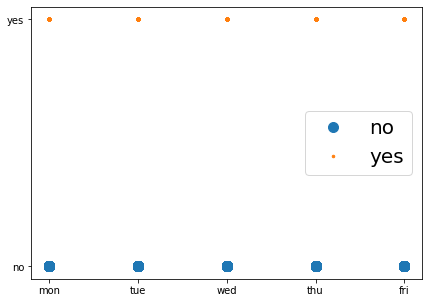

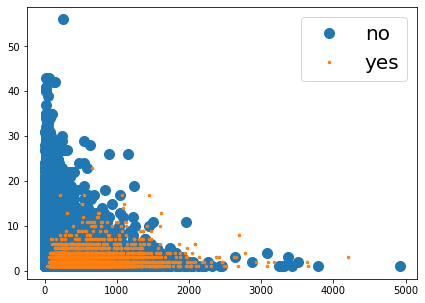

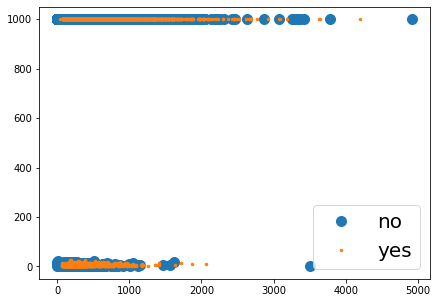

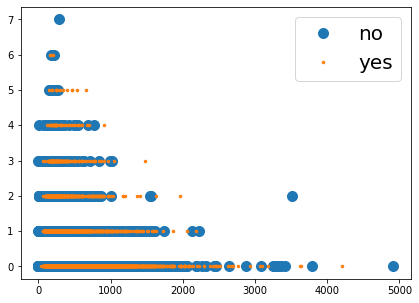

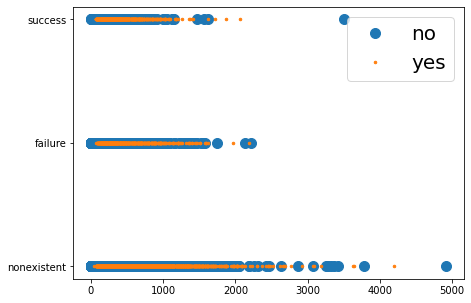

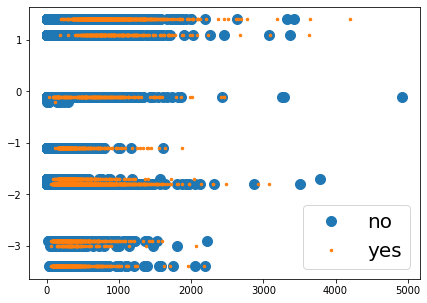

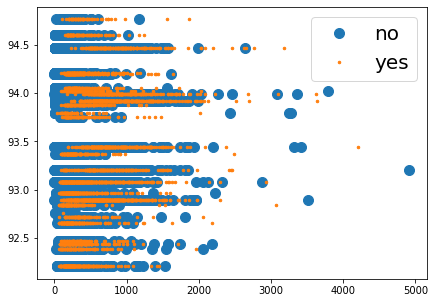

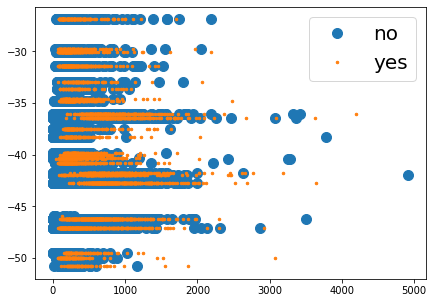

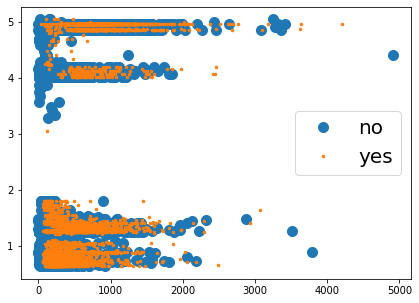

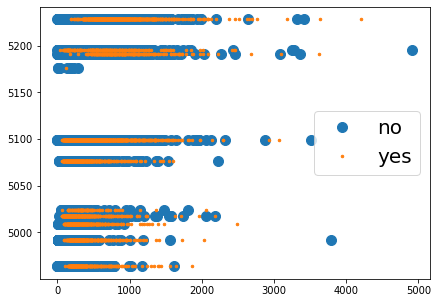

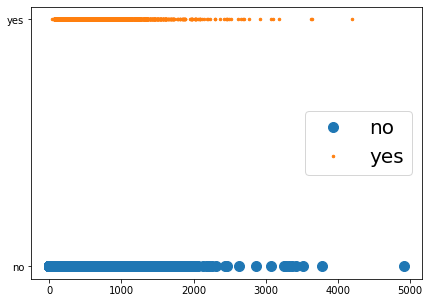

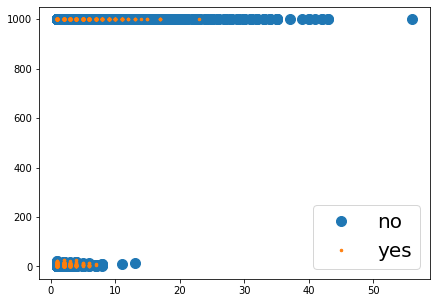

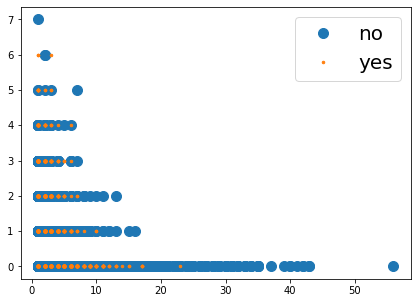

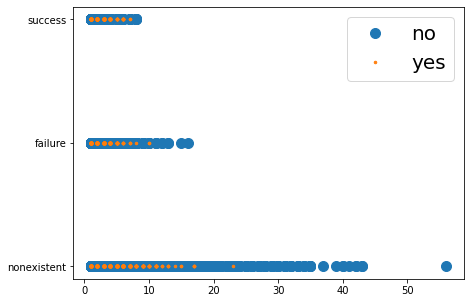

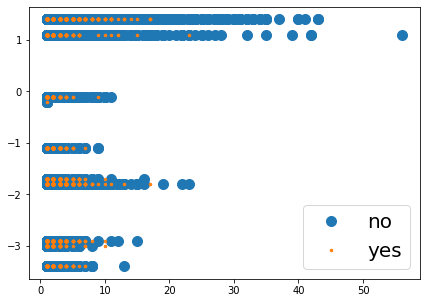

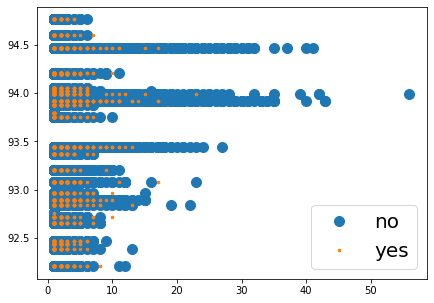

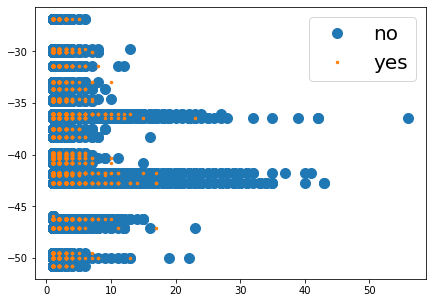

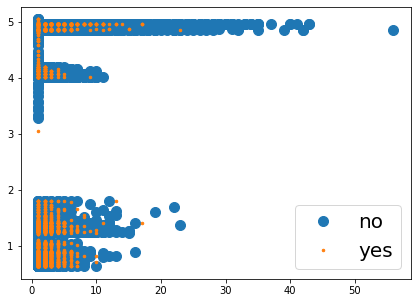

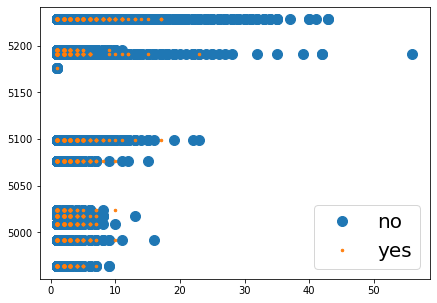

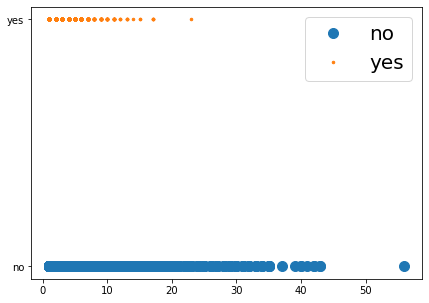

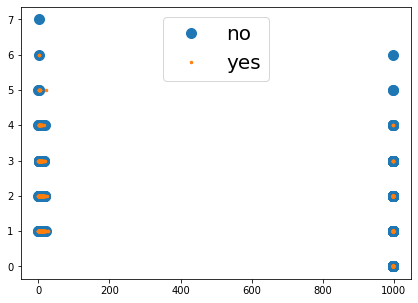

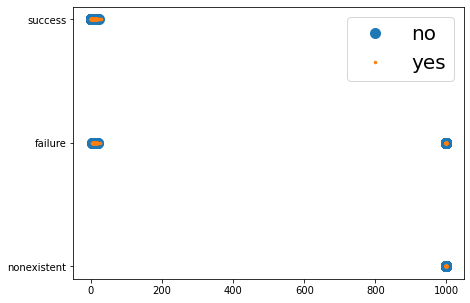

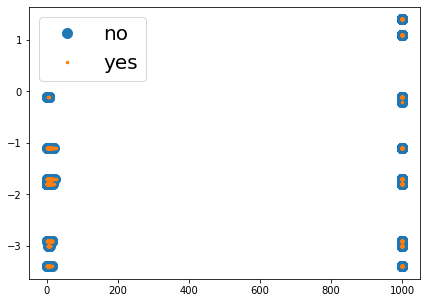

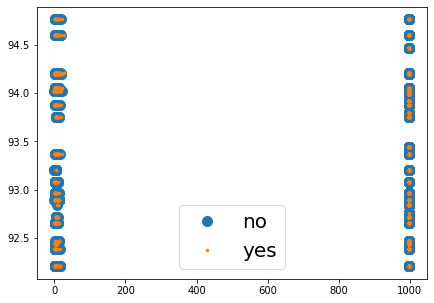

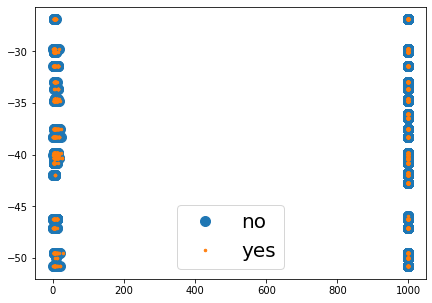

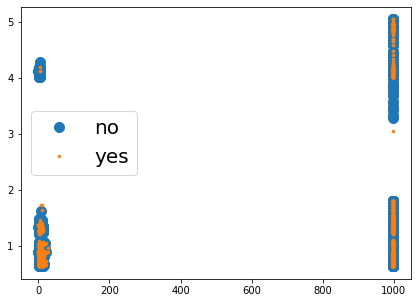

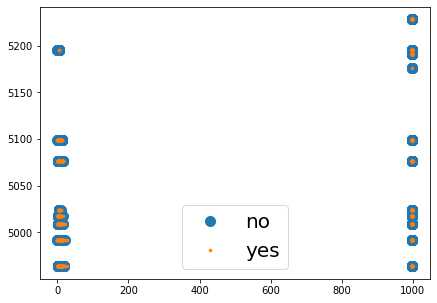

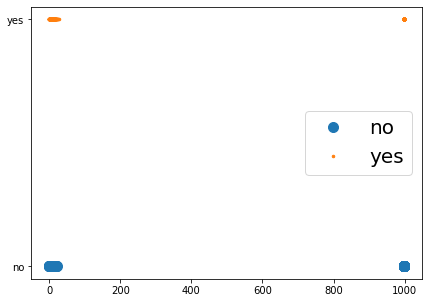

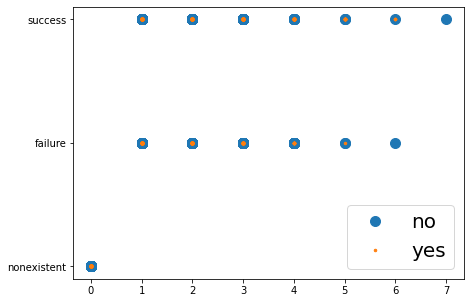

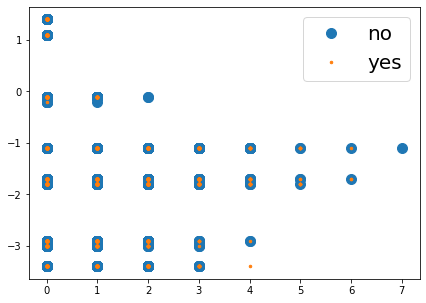

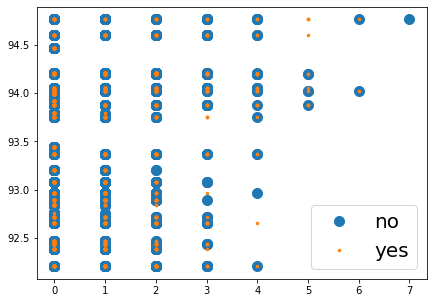

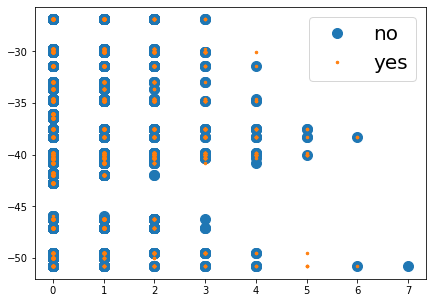

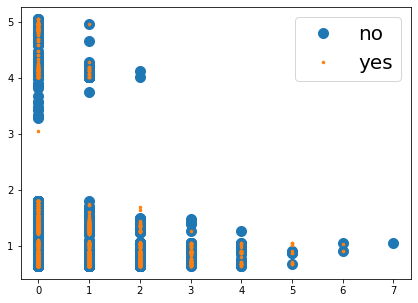

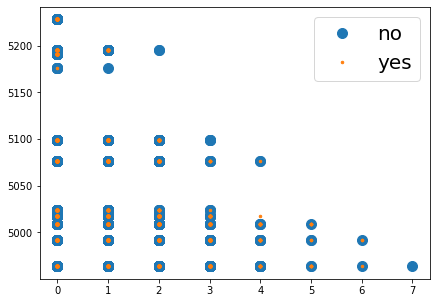

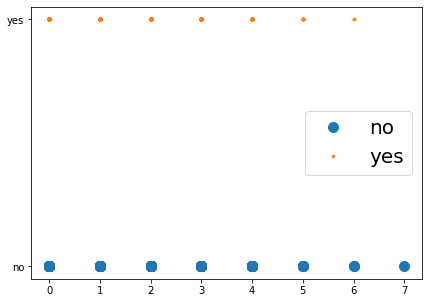

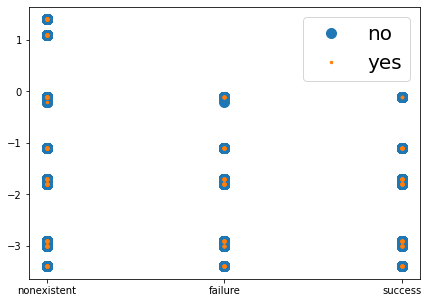

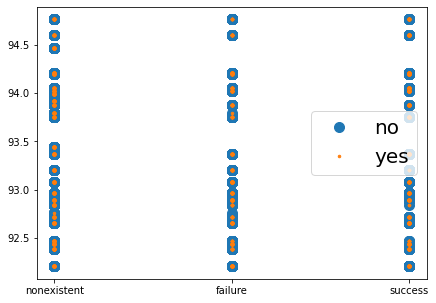

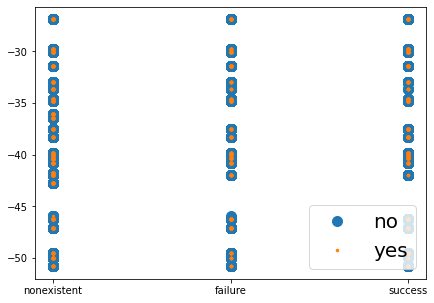

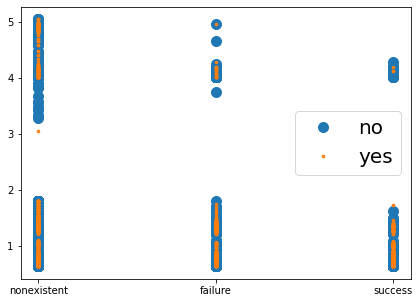

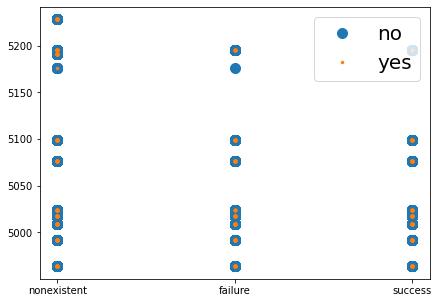

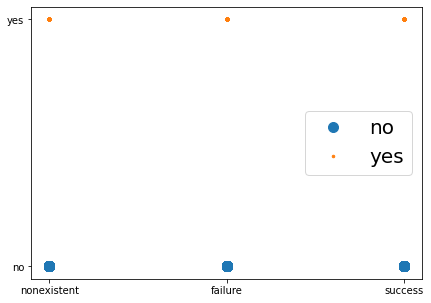

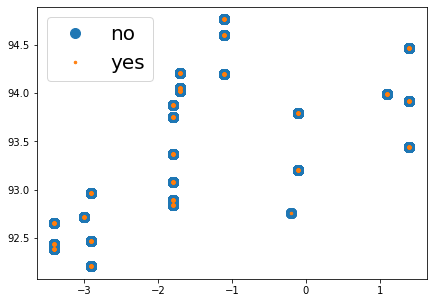

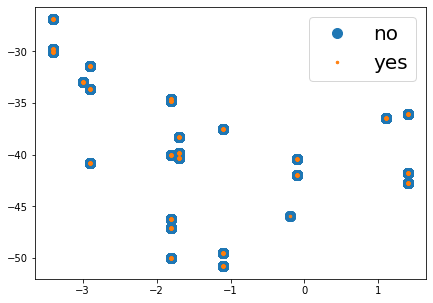

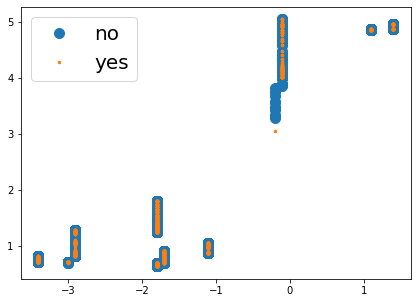

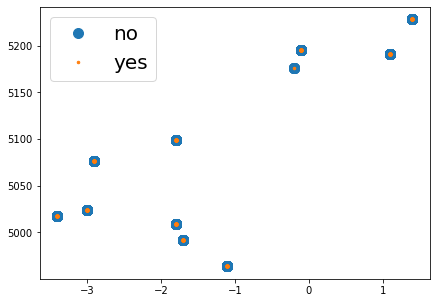

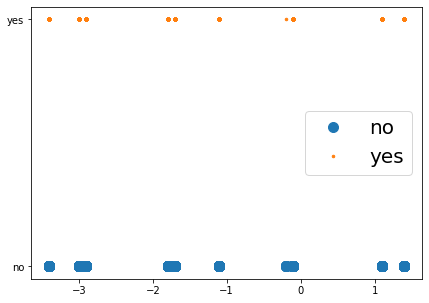

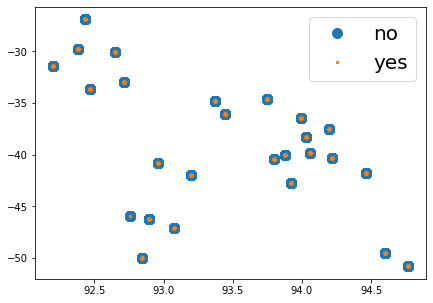

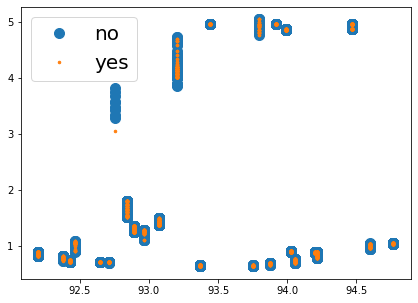

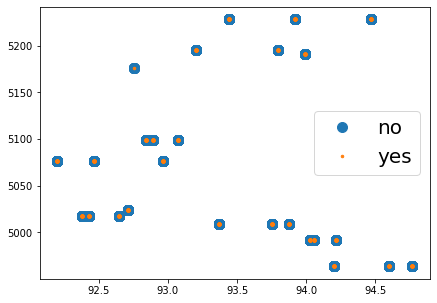

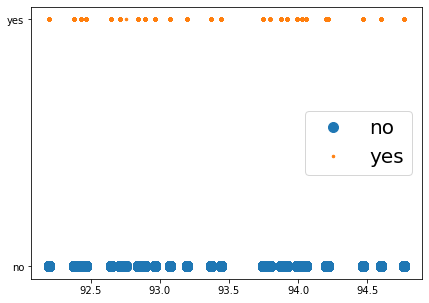

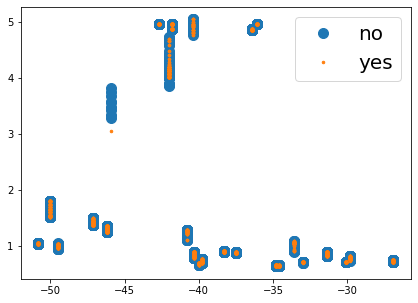

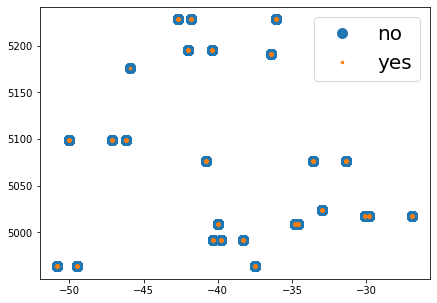

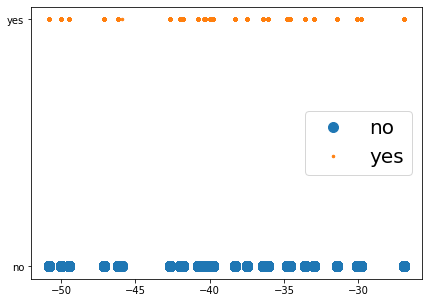

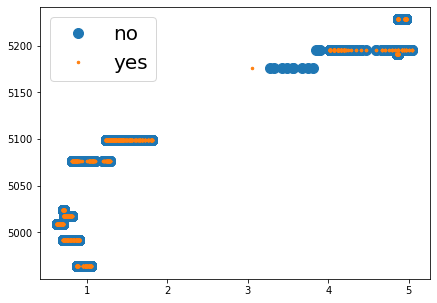

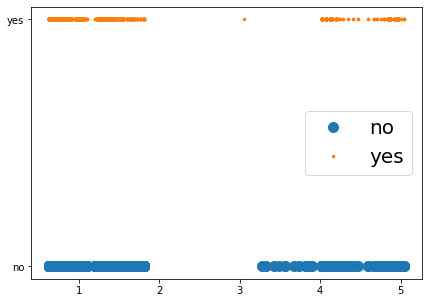

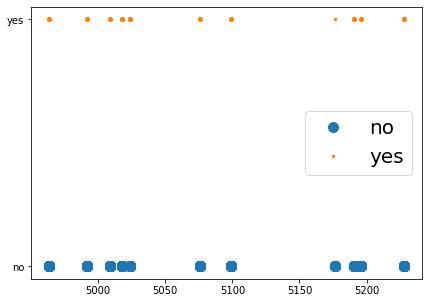

In [100]:
_list = df.columns
for _i in range(len(_list)):
    for _j in range(1,len(_list)):
        if _j > _i:
            plotContinuous(df,_list[_i],_list[_j],[20,5],[7,5])

In [103]:
for column in df.columns:
    if df[column].dtype != object:
        print('{} range : {}'.format(column, df[column].max()-df[column].min()))

age range : 81
duration range : 4918
campaign range : 55
pdays range : 999
previous range : 7
emp.var.rate range : 4.8
cons.price.idx range : 2.5660000000000025
cons.conf.idx range : 23.9
euribor3m range : 4.411
nr.employed range : 264.5


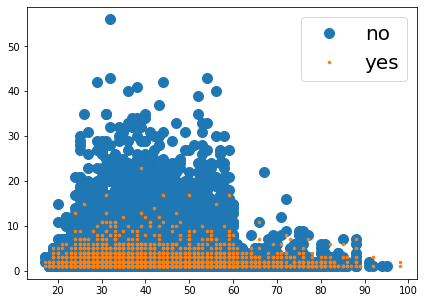

In [105]:
plotContinuous(df,'age','campaign',[20,5],[7,5])